In [2]:
import pandas as pd
import numpy as np
import wfdb
from tqdm import tqdm
import ast
import seaborn as sns
import matplotlib.pyplot as plt

import cv2



In [3]:
# from skimage.morphology import skeletonize
# from scipy import ndimage
from scipy import signal
import tensorflow as tf


In [4]:
path = './ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'

In [24]:
sampling_rate=500

In [25]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_lr)]
    else:
        data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_hr)]
    data = np.array([signal for signal, meta in data])
    return data

In [26]:
ecgdf = pd.read_csv(f'{path}/ptbxl_database.csv',index_col='ecg_id')

In [27]:
ecgdf.head()

patient_id   age  sex  height  weight  nurse  site     device  \
ecg_id                                                                  
1          15709.0  56.0    1     NaN    63.0    2.0   0.0  CS-12   E   
2          13243.0  19.0    0     NaN    70.0    2.0   0.0  CS-12   E   
3          20372.0  37.0    1     NaN    69.0    2.0   0.0  CS-12   E   
4          17014.0  24.0    0     NaN    82.0    2.0   0.0  CS-12   E   
5          17448.0  19.0    1     NaN    70.0    2.0   0.0  CS-12   E   

             recording_date                                  report  ...  \
ecg_id                                                               ...   
1       1984-11-09 09:17:34  sinusrhythmus periphere niederspannung  ...   
2       1984-11-14 12:55:37     sinusbradykardie sonst normales ekg  ...   
3       1984-11-15 12:49:10              sinusrhythmus normales ekg  ...   
4       1984-11-15 13:44:57              sinusrhythmus normales ekg  ...   
5       1984-11-17 10:43:15              sinusrhythmus normales ekg  ...   

       validated_by_human  baseline_drift static_noise burst_noise  \
ecg_id                                                               
1                    True             NaN    , I-V1,           NaN   
2                    True             NaN          NaN         NaN   
3                    True             NaN          NaN         NaN   
4                    True    , II,III,AVF          NaN         NaN   
5                    True   , III,AVR,AVF          NaN         NaN   

        electrodes_problems  extra_beats  pacemaker  strat_fold  \
ecg_id                                                            
1                       NaN          NaN        NaN           3   
2                       NaN          NaN        NaN           2   
3                       NaN          NaN        NaN           5   
4                       NaN          NaN        NaN           3   
5                       NaN          NaN        NaN           4   

                      filename_lr                filename_hr  
ecg_id                                                        
1       records100/00000/00001_lr  records500/00000/00001_hr  
2       records100/00000/00002_lr  records500/00000/00002_hr  
3       records100/00000/00003_lr  records500/00000/00003_hr  
4       records100/00000/00004_lr  records500/00000/00004_hr  
5       records100/00000/00005_lr  records500/00000/00005_hr  

[5 rows x 27 columns]

In [28]:
ecgdf.scp_codes = ecgdf.scp_codes.apply(lambda x: ast.literal_eval(x))

In [29]:
ecg = load_raw_data(ecgdf, sampling_rate, path)

100%|██████████| 21837/21837 [00:50<00:00, 431.64it/s]


In [10]:
ecgdf.filename_lr

ecg_id
1        records100/00000/00001_lr
2        records100/00000/00002_lr
3        records100/00000/00003_lr
4        records100/00000/00004_lr
5        records100/00000/00005_lr
                   ...            
21833    records100/21000/21833_lr
21834    records100/21000/21834_lr
21835    records100/21000/21835_lr
21836    records100/21000/21836_lr
21837    records100/21000/21837_lr
Name: filename_lr, Length: 21837, dtype: object

In [11]:
ecgdf.filename_hr

ecg_id
1        records500/00000/00001_hr
2        records500/00000/00002_hr
3        records500/00000/00003_hr
4        records500/00000/00004_hr
5        records500/00000/00005_hr
                   ...            
21833    records500/21000/21833_hr
21834    records500/21000/21834_hr
21835    records500/21000/21835_hr
21836    records500/21000/21836_hr
21837    records500/21000/21837_hr
Name: filename_hr, Length: 21837, dtype: object

In [30]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print(agg_df.shape)
agg_df.head()

(44, 12)


description  diagnostic  form  rhythm  \
NDT    non-diagnostic T abnormalities         1.0   1.0     NaN   
NST_          non-specific ST changes         1.0   1.0     NaN   
DIG                  digitalis-effect         1.0   1.0     NaN   
LNGQT                long QT-interval         1.0   1.0     NaN   
NORM                       normal ECG         1.0   NaN     NaN   

      diagnostic_class diagnostic_subclass  \
NDT               STTC                STTC   
NST_              STTC                NST_   
DIG               STTC                STTC   
LNGQT             STTC                STTC   
NORM              NORM                NORM   

                                      Statement Category  \
NDT                    other ST-T descriptive statements   
NST_   Basic roots for coding ST-T changes and abnorm...   
DIG                    other ST-T descriptive statements   
LNGQT                  other ST-T descriptive statements   
NORM                                     Normal/abnormal   

        SCP-ECG Statement Description  AHA code            aECG REFID  \
NDT    non-diagnostic T abnormalities       NaN                   NaN   
NST_          non-specific ST changes     145.0  MDC_ECG_RHY_STHILOST   
DIG         suggests digitalis-effect     205.0                   NaN   
LNGQT                long QT-interval     148.0                   NaN   
NORM                       normal ECG       1.0                   NaN   

      CDISC Code DICOM Code  
NDT          NaN        NaN  
NST_         NaN        NaN  
DIG          NaN        NaN  
LNGQT        NaN        NaN  
NORM         NaN    F-000B7

In [13]:
agg_df.index

Index(['NDT', 'NST_', 'DIG', 'LNGQT', 'NORM', 'IMI', 'ASMI', 'LVH', 'LAFB',
       'ISC_', 'IRBBB', '1AVB', 'IVCD', 'ISCAL', 'CRBBB', 'CLBBB', 'ILMI',
       'LAO/LAE', 'AMI', 'ALMI', 'ISCIN', 'INJAS', 'LMI', 'ISCIL', 'LPFB',
       'ISCAS', 'INJAL', 'ISCLA', 'RVH', 'ANEUR', 'RAO/RAE', 'EL', 'WPW',
       'ILBBB', 'IPLMI', 'ISCAN', 'IPMI', 'SEHYP', 'INJIN', 'INJLA', 'PMI',
       '3AVB', 'INJIL', '2AVB'],
      dtype='object')

In [14]:
ecgdf.scp_codes

ecg_id
1                 {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
2                             {'NORM': 80.0, 'SBRAD': 0.0}
3                               {'NORM': 100.0, 'SR': 0.0}
4                               {'NORM': 100.0, 'SR': 0.0}
5                               {'NORM': 100.0, 'SR': 0.0}
                               ...                        
21833    {'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...
21834             {'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}
21835                           {'ISCAS': 50.0, 'SR': 0.0}
21836                           {'NORM': 100.0, 'SR': 0.0}
21837                           {'NORM': 100.0, 'SR': 0.0}
Name: scp_codes, Length: 21837, dtype: object

In [31]:
def aggregate_supclass_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))
    
# Apply diagnostic superclass
ecgdf['diagnostic_superclass'] = ecgdf.scp_codes.apply(aggregate_supclass_diagnostic)
ecgdf['diagnostic_superclass_len'] = ecgdf['diagnostic_superclass'].apply(len)
ecgdf.loc[ecgdf.diagnostic_superclass_len > 1, 'diagnostic_superclass']

ecg_id
39       [MI, STTC]
45        [CD, HYP]
50         [MI, CD]
77         [MI, CD]
87       [CD, STTC]
            ...    
21815      [MI, CD]
21821    [CD, NORM]
21827    [MI, STTC]
21828    [MI, STTC]
21829    [CD, NORM]
Name: diagnostic_superclass, Length: 5158, dtype: object

In [32]:
def aggregate_subclass_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_subclass)
    ret = list(set(tmp))
    ret = ['sub_'+r for r in ret] # to distinguish between subclass and superclass columns
    return ret

# Apply diagnostic subclass
ecgdf['diagnostic_subclass'] = ecgdf.scp_codes.apply(aggregate_subclass_diagnostic)
ecgdf['diagnostic_subclass_len'] = ecgdf['diagnostic_subclass'].apply(len)
ecgdf.loc[ecgdf.diagnostic_subclass_len > 1, 'diagnostic_subclass']

ecg_id
26                    [sub_NST_, sub_STTC]
28                    [sub_NST_, sub_STTC]
39           [sub_IMI, sub_NST_, sub_STTC]
45       [sub_RAO/RAE, sub_IRBBB, sub_RVH]
50                     [sub_IVCD, sub_LMI]
                       ...                
21821                [sub_IRBBB, sub_NORM]
21827                  [sub_IMI, sub_ISCA]
21828                  [sub_IMI, sub_ISCA]
21829                [sub_IRBBB, sub_NORM]
21832            [sub_IVCD, sub_LAFB/LPFB]
Name: diagnostic_subclass, Length: 6191, dtype: object

In [33]:
all_superclass = pd.Series(np.concatenate(ecgdf['diagnostic_superclass'].values))
all_subclass = pd.Series(np.concatenate(ecgdf['diagnostic_subclass'].values))
superclass_cols = all_superclass.unique()
subclass_cols = all_subclass.unique()
update_cols = np.concatenate([superclass_cols, subclass_cols]) # add meta data columns
meta_cols = ['age', 'sex', 'height', 'weight', 'nurse', 'site', 'device',] # could add more columns as features

In [34]:
class ClassUpdate():
    def __init__(self, cols):
        self.cols = cols

    def __call__(self, row):
        for sc in row['diagnostic_superclass']:
            row[sc] = 1
        for sc in row['diagnostic_subclass']:
            row[sc] = 1
            
        return row

def get_data_by_folds(folds, x, y, update_cols, feature_cols):
    assert len(folds)  > 0, '# of provided folds should longer than 1'
    #print(y.strat_fold)
    filt = np.isin(y.strat_fold.values, folds)
    x_selected = x[filt]
    y_selected = y[filt]
    
    for sc in update_cols:
        y_selected[sc] = 0
        
    cls_updt = ClassUpdate(update_cols)
    
    y_selected = y_selected.apply(cls_updt, axis=1)
    
    return x_selected, y_selected[list(feature_cols)+list(update_cols)+['strat_fold']]

x_all, y_all = get_data_by_folds(np.arange(1, 11), ecg, ecgdf, update_cols, meta_cols)


In [35]:
def plot_superclass(superclass):
    filt = y_all[superclass] == 1
    y_selected = y_all.loc[filt]
    x_selected = x_all[filt]
    
    for i in range(sample_num):
        y_ = y_selected.iloc[i]
        x_ = x_selected[i]
        
        #display(y_)
        #print(y_.shape, x_.shape); assert False
        bar, axes = plt.subplots(x_.shape[1], 1, figsize=(10,10))
        title = "Superclass = {}, Age = {}, Height = {}, Weight = {}, Sex = {}, Nurse = {}, Site = {}, Device = {}".format(superclass, 
                                                                                                                           y_['age'], y_['height'], y_['weight'],
                                                                                                                           y_['sex'], y_['nurse'], y_['site'], y_['device'],)
        axes[0].set_title(title, fontsize=15)
        
        for c in np.arange(x_.shape[1]):
            sns.lineplot(x=np.arange(x_.shape[0]), y=x_[:, c], ax=axes[c])
        
        plt.tight_layout()
        plt.show()
        #assert False

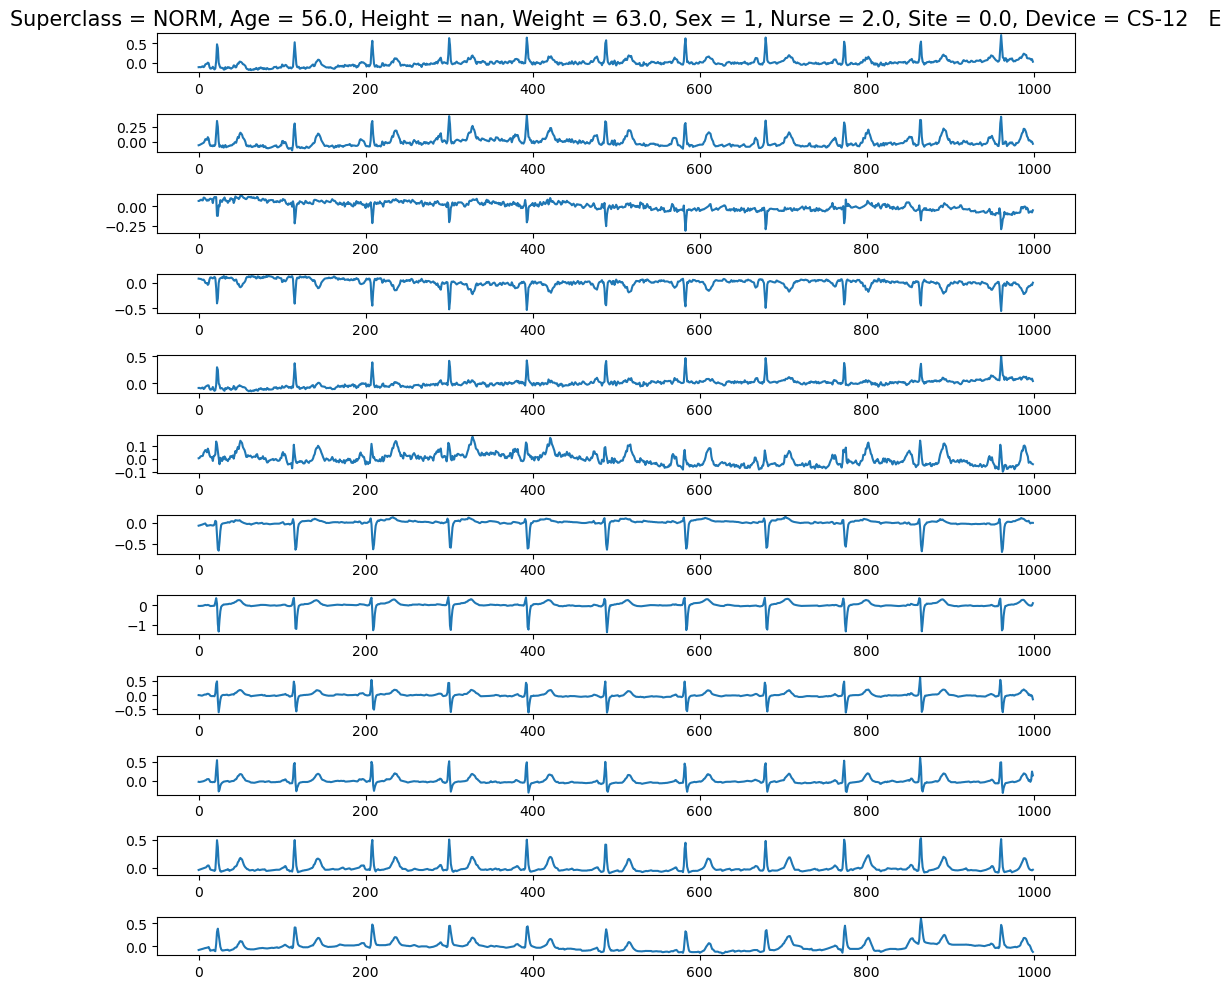

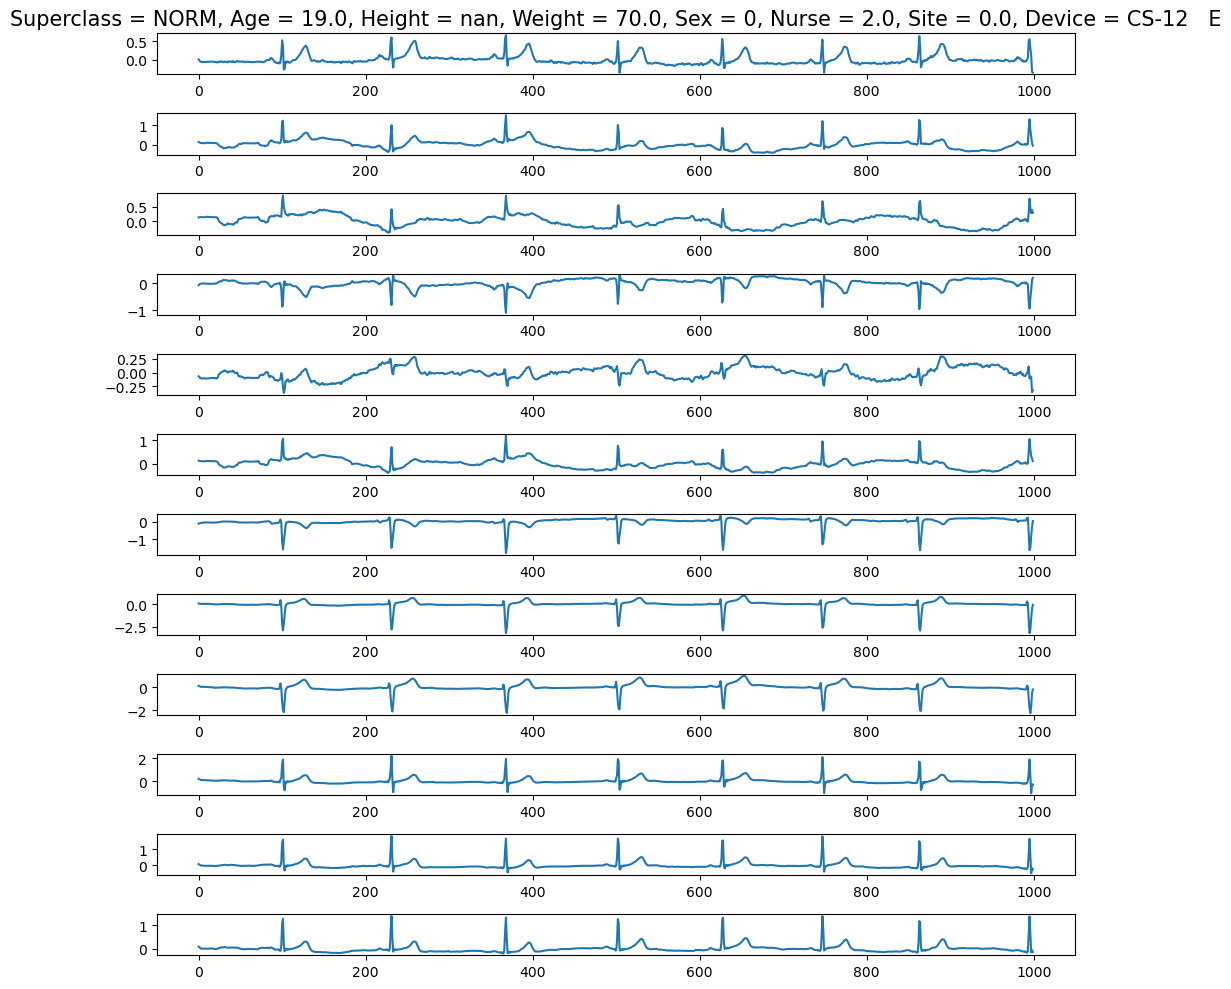

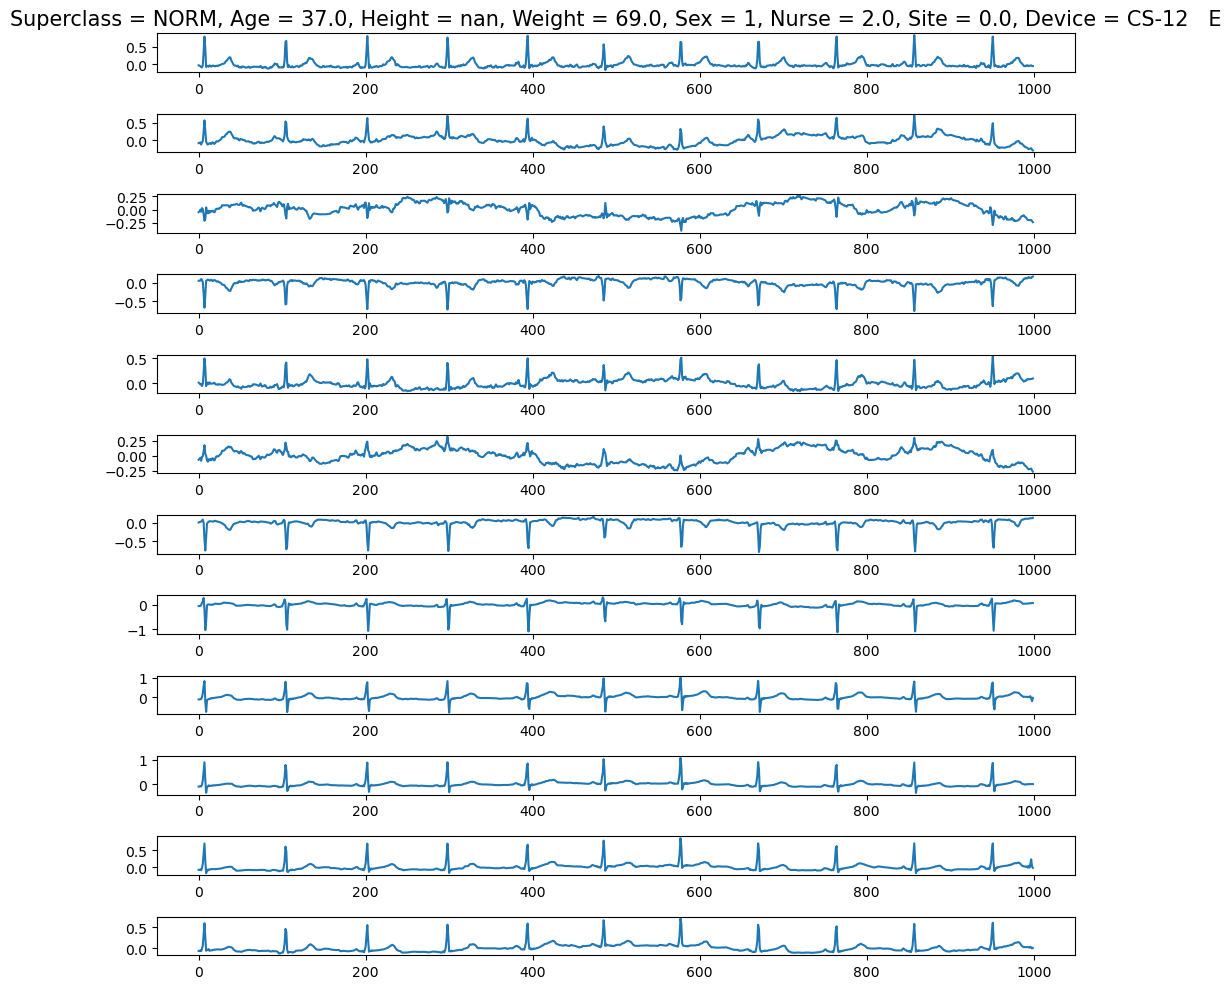

In [20]:
sample_num = 3
plot_superclass('NORM')

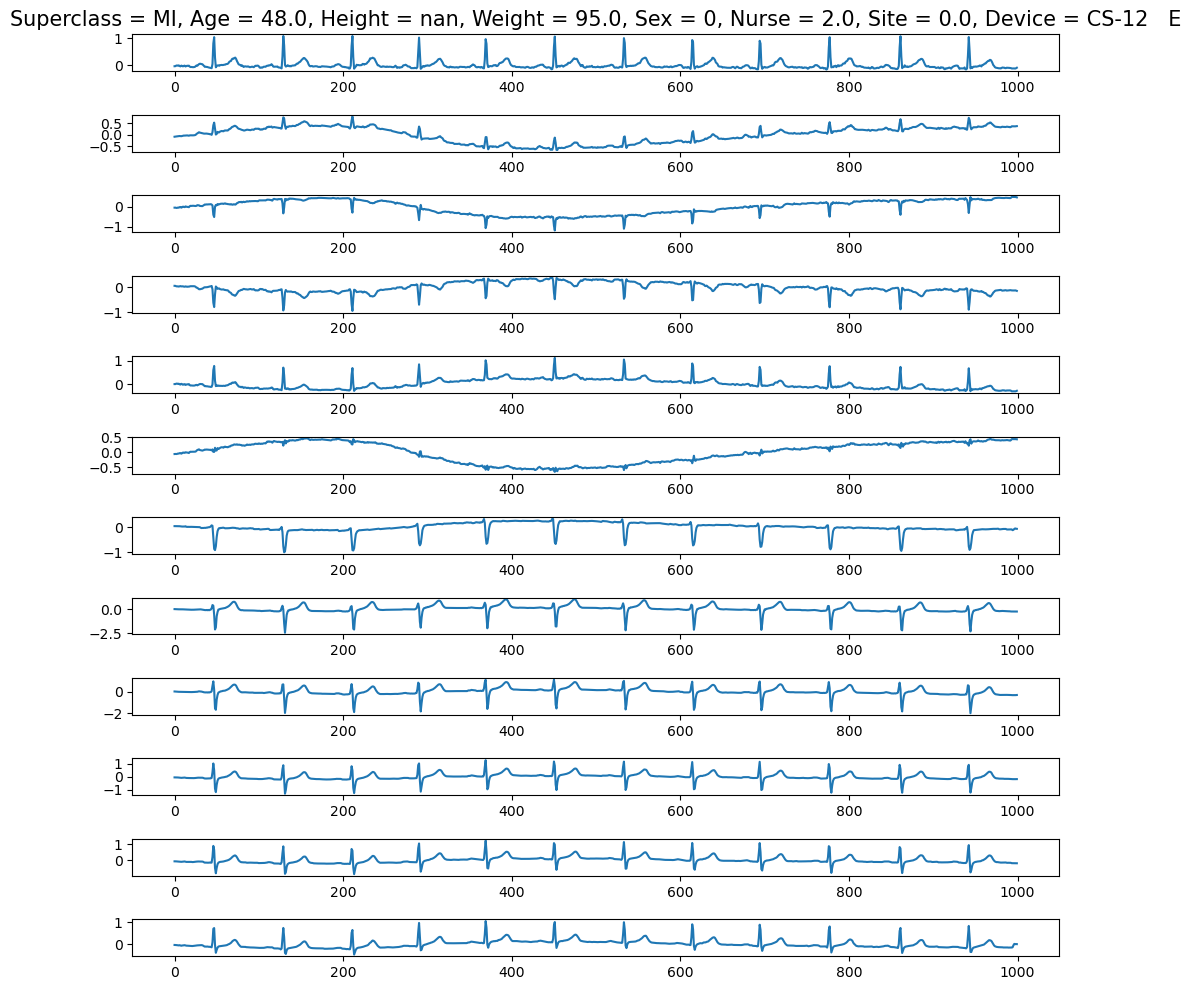

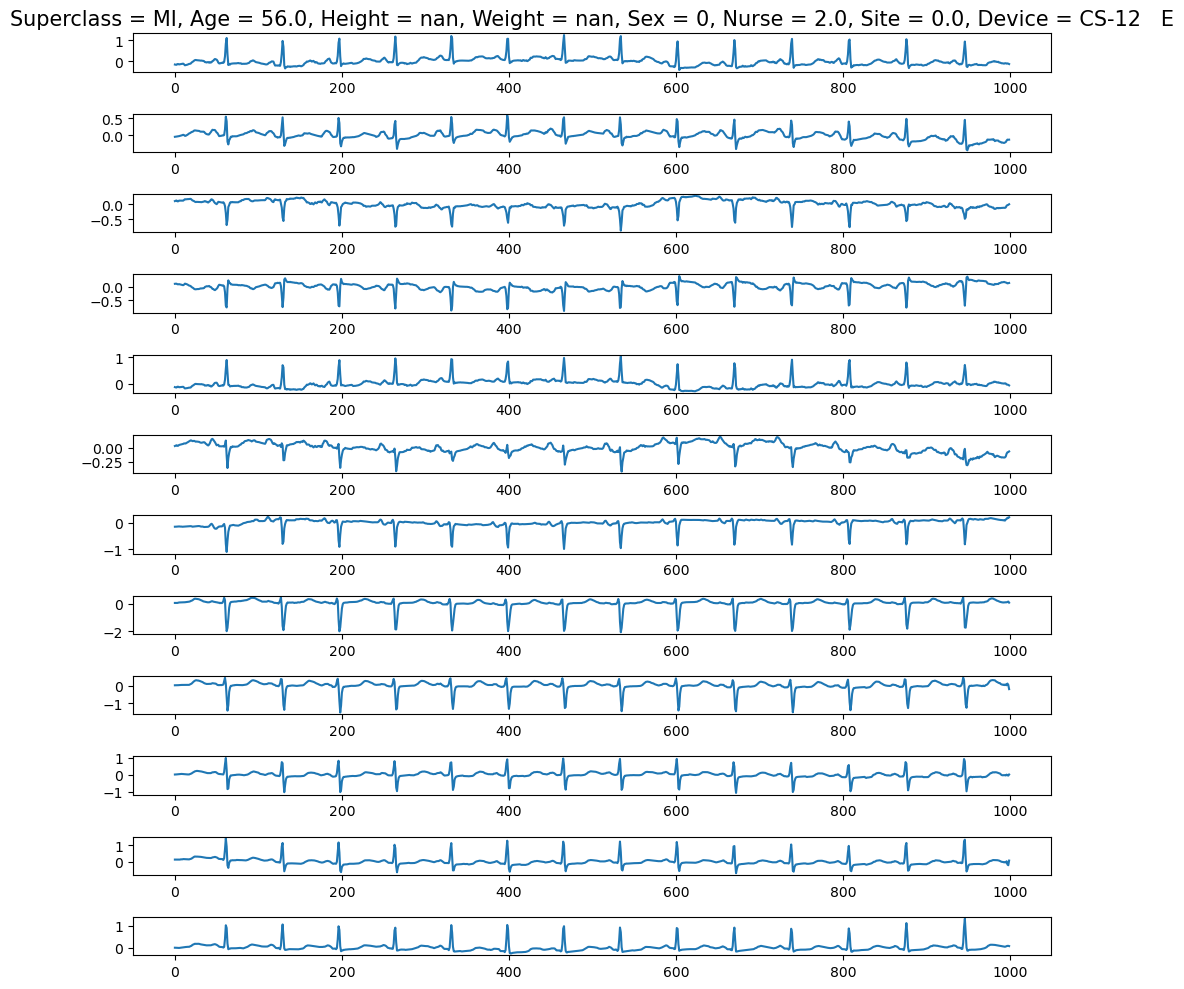

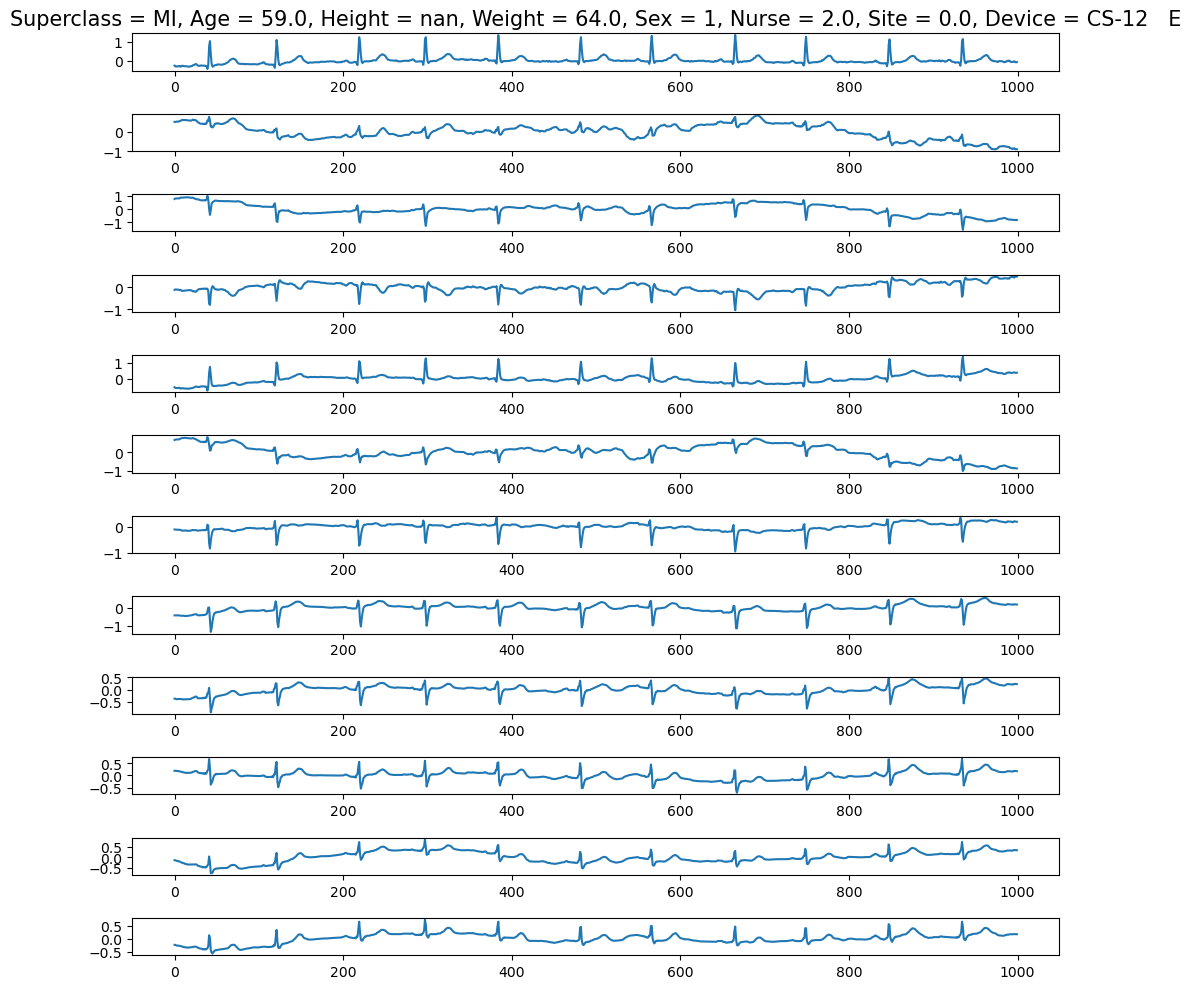

In [21]:
sample_num = 3
plot_superclass('MI')

---

Filters for data:

In [110]:
y_all

age  sex  height  weight  nurse  site      device  NORM  MI  STTC  \
ecg_id                                                                       
1       56.0    1     NaN    63.0    2.0   0.0   CS-12   E     1   0     0   
2       19.0    0     NaN    70.0    2.0   0.0   CS-12   E     1   0     0   
3       37.0    1     NaN    69.0    2.0   0.0   CS-12   E     1   0     0   
4       24.0    0     NaN    82.0    2.0   0.0   CS-12   E     1   0     0   
5       19.0    1     NaN    70.0    2.0   0.0   CS-12   E     1   0     0   
...      ...  ...     ...     ...    ...   ...         ...   ...  ..   ...   
21833   67.0    1     NaN     NaN    1.0   2.0  AT-60    3     0   0     1   
21834   93.0    0     NaN     NaN    1.0   2.0  AT-60    3     1   0     0   
21835   59.0    1     NaN     NaN    1.0   2.0  AT-60    3     0   0     1   
21836   64.0    1     NaN     NaN    1.0   2.0  AT-60    3     1   0     0   
21837   68.0    0     NaN     NaN    1.0   2.0  AT-60    3     1   0     0   

        ...  sub_ISC_  sub_SEHYP  sub_ISCI  sub_CRBBB  sub_CLBBB  sub_LAO/LAE  \
ecg_id  ...                                                                     
1       ...         0          0         0          0          0            0   
2       ...         0          0         0          0          0            0   
3       ...         0          0         0          0          0            0   
4       ...         0          0         0          0          0            0   
5       ...         0          0         0          0          0            0   
...     ...       ...        ...       ...        ...        ...          ...   
21833   ...         0          0         0          0          0            0   
21834   ...         0          0         0          0          0            0   
21835   ...         0          0         0          0          0            0   
21836   ...         0          0         0          0          0            0   
21837   ...         0          0         0          0          0            0   

        sub_ILBBB  sub_WPW  sub_PMI  strat_fold  
ecg_id                                           
1               0        0        0           3  
2               0        0        0           2  
3               0        0        0           5  
4               0        0        0           3  
5               0        0        0           4  
...           ...      ...      ...         ...  
21833           0        0        0           7  
21834           0        0        0           4  
21835           0        0        0           2  
21836           0        0        0           8  
21837           0        0        0           9  

[21837 rows x 36 columns]

In [115]:
final_ecg_df = y_all.copy()

In [118]:
x_all.shape

(21837, 1000, 12)

In [112]:
final_ecg_df['ecg_heads'] = x_all

In [119]:
final_ecg_df.shape

(21837, 36)

In [132]:
final_ecg_df['ecg_heads'] = list(x_all.transpose(0, 2, 1))


In [133]:
final_ecg_df.head()

age  sex  height  weight  nurse  site     device  NORM  MI  STTC  \
ecg_id                                                                      
1       56.0    1     NaN    63.0    2.0   0.0  CS-12   E     1   0     0   
2       19.0    0     NaN    70.0    2.0   0.0  CS-12   E     1   0     0   
3       37.0    1     NaN    69.0    2.0   0.0  CS-12   E     1   0     0   
4       24.0    0     NaN    82.0    2.0   0.0  CS-12   E     1   0     0   
5       19.0    1     NaN    70.0    2.0   0.0  CS-12   E     1   0     0   

        ...  sub_SEHYP  sub_ISCI  sub_CRBBB  sub_CLBBB  sub_LAO/LAE  \
ecg_id  ...                                                           
1       ...          0         0          0          0            0   
2       ...          0         0          0          0            0   
3       ...          0         0          0          0            0   
4       ...          0         0          0          0            0   
5       ...          0         0          0          0            0   

        sub_ILBBB  sub_WPW  sub_PMI  strat_fold  \
ecg_id                                            
1               0        0        0           3   
2               0        0        0           2   
3               0        0        0           5   
4               0        0        0           3   
5               0        0        0           4   

                                                ecg_heads  
ecg_id                                                     
1       [[-0.119, -0.116, -0.12, -0.117, -0.103, -0.09...  
2       [[0.004, -0.02, -0.053, -0.056, -0.062, -0.065...  
3       [[-0.029, -0.035, -0.054, -0.078, -0.088, -0.0...  
4       [[-0.054, -0.053, -0.063, -0.06, -0.05, -0.054...  
5       [[-0.034, -0.038, -0.057, -0.066, -0.08, -0.08...  

[5 rows x 37 columns]

for final_ecg_df col 'ecg_heads' apply transpose(0, 2, 1)

In [134]:
final_ecg_df['ecg_heads'][1].shape

(12, 1000)

prepare final_ecg_df for teaining of ml model. TO do that shuffle the df then split it into 3 train, test, val in ration 6:2:2. set ecg_heads col as model input .['NORM','MI','STTC', 'HYP', 'CD'] cols are classes they are hot encoded so they the classes so they are model output.

In [135]:
# Shuffle the DataFrame and split into train, test, val (60:20:20)
df_shuffled = final_ecg_df.sample(frac=1, random_state=42).reset_index(drop=True)
n = len(df_shuffled)
train_end = int(0.6 * n)
test_end = train_end + int(0.2 * n)

train_df = df_shuffled.iloc[:train_end]
test_df = df_shuffled.iloc[train_end:test_end]
val_df = df_shuffled.iloc[test_end:]

# Set model input as ecg_heads and model output as hot-encoded classes ['NORM','MI','STTC','HYP','CD']
X_train = np.array(train_df['ecg_heads'].tolist())
X_test = np.array(test_df['ecg_heads'].tolist())
X_val = np.array(val_df['ecg_heads'].tolist())

target_columns = ['NORM', 'MI', 'STTC', 'HYP', 'CD']
y_train = train_df[target_columns].values
y_test = test_df[target_columns].values
y_val = val_df[target_columns].values

print("Training samples:", X_train.shape, y_train.shape)
print("Testing samples:", X_test.shape, y_test.shape)
print("Validation samples:", X_val.shape, y_val.shape)

Training samples: (13102, 12, 1000) (13102, 5)
Testing samples: (4367, 12, 1000) (4367, 5)
Validation samples: (4368, 12, 1000) (4368, 5)


In [208]:
X_train = np.expand_dims(np.array(train_df['ecg_heads'].tolist()), -1)

In [209]:
X_train.shape

(13102, 12, 1000, 1)

In [22]:
y_all.columns.to_list()

['age',
 'sex',
 'height',
 'weight',
 'nurse',
 'site',
 'device',
 'NORM',
 'MI',
 'STTC',
 'HYP',
 'CD',
 'sub_NORM',
 'sub_IMI',
 'sub_STTC',
 'sub_NST_',
 'sub_LVH',
 'sub_LAFB/LPFB',
 'sub_RAO/RAE',
 'sub_IRBBB',
 'sub_RVH',
 'sub_IVCD',
 'sub_LMI',
 'sub_AMI',
 'sub__AVB',
 'sub_ISCA',
 'sub_ISC_',
 'sub_SEHYP',
 'sub_ISCI',
 'sub_CRBBB',
 'sub_CLBBB',
 'sub_LAO/LAE',
 'sub_ILBBB',
 'sub_WPW',
 'sub_PMI',
 'strat_fold']

In [109]:
512//2

256

In [48]:
64//2

32

In [107]:
x_selected = x_all[y_all['NORM'] == 1]

In [108]:
x_selected.shape

(9528, 1000, 12)

In [25]:
test = x_selected.transpose(0, 2, 1)

In [26]:
x_selected[0]

array([[-0.119, -0.055,  0.064, ..., -0.026, -0.039, -0.079],
       [-0.116, -0.051,  0.065, ..., -0.031, -0.034, -0.074],
       [-0.12 , -0.044,  0.076, ..., -0.028, -0.029, -0.069],
       ...,
       [ 0.069,  0.   , -0.069, ...,  0.024, -0.041, -0.058],
       [ 0.086,  0.004, -0.081, ...,  0.242, -0.046, -0.098],
       [ 0.022, -0.031, -0.054, ...,  0.143, -0.035, -0.12 ]])

In [27]:
sample_data =  test[0][0]

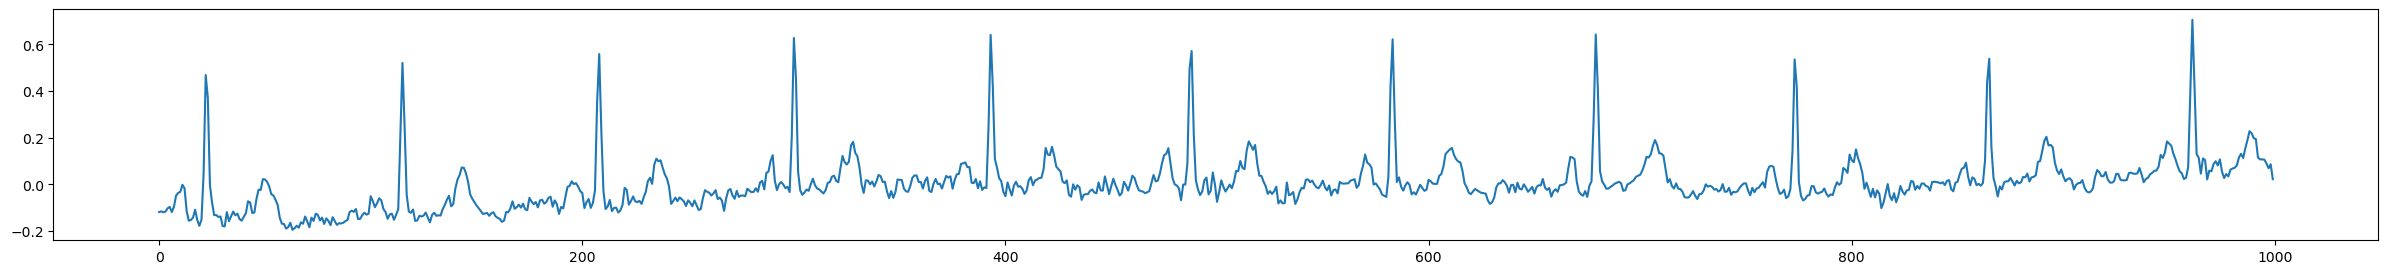

In [28]:
plt.figure(figsize=(30, 3))
plt.plot(sample_data)
plt.show()

In [29]:
fs = 4

In [30]:
clean_rr_interpolated_ecg = sample_data

In [31]:
# clean_rr_interpolated_ecg = np.sin(2 * np.pi * 0.1 * sample_data) + 0.5 * np.random.randn(len(sample_data))

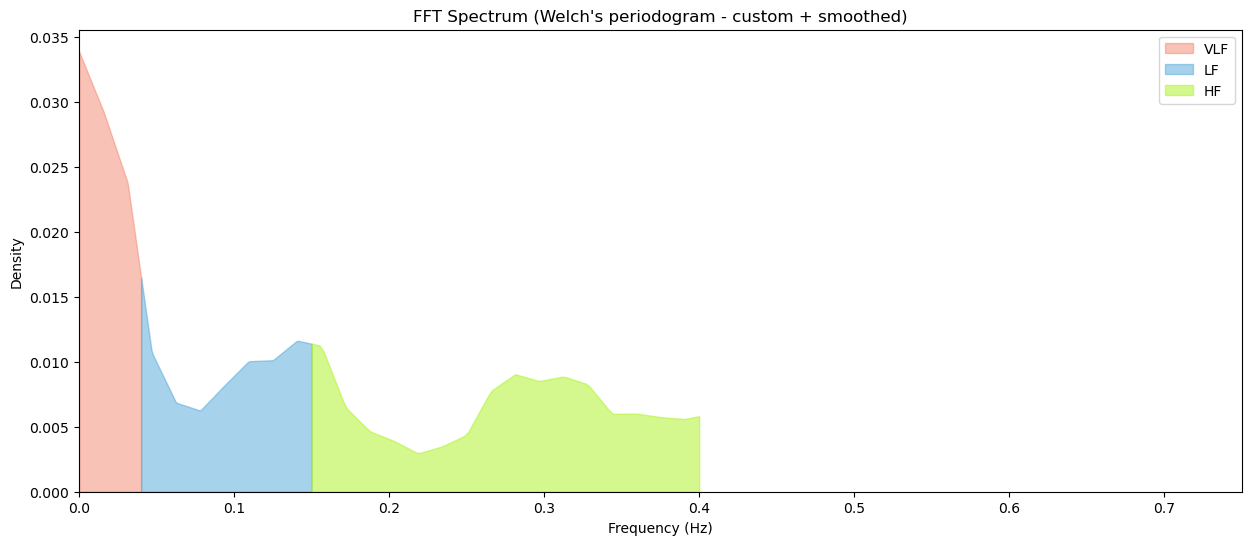

In [32]:
# Compute Welch's approximation manually (same as before)
def custom_welch(x, fs, nperseg):
    step = nperseg // 2
    segments = []
    for start in range(0, len(x) - nperseg + 1, step):
        segment = x[start:start + nperseg]
        window = np.hanning(nperseg)
        segment = segment * window
        freqs = np.fft.rfftfreq(nperseg, 1 / fs)
        fft_vals = np.fft.rfft(segment)
        psd = (np.abs(fft_vals) ** 2) / (fs * np.sum(window**2))
        segments.append(psd)
    segments = np.array(segments)
    avg_psd = np.mean(segments, axis=0)
    return freqs, avg_psd

fxx, pxx = custom_welch(clean_rr_interpolated_ecg, fs=fs, nperseg=256)

# Smooth PSD using Pandas rolling mean (window=5 points)
psd_smoothed = pd.Series(pxx).rolling(window=5, center=True, min_periods=1).mean()

# Function to approximate PSD at arbitrary frequencies
def powerspectrum_f(x_query):
    return np.interp(x_query, fxx, psd_smoothed)

# Plotting
plt.figure(figsize=(15,6))
plt.title("FFT Spectrum (Welch's periodogram - custom + smoothed)")

# Setup frequency bands for plotting (same bands)
x_VLF = np.linspace(0, 0.04, 100)
x_LF = np.linspace(0.04, 0.15, 100)
x_HF = np.linspace(0.15, 0.4, 100)

plt.fill_between(x_VLF, powerspectrum_f(x_VLF), alpha=0.5, color="#F5866F", label="VLF")
plt.fill_between(x_LF, powerspectrum_f(x_LF), alpha=0.5, color="#51A6D8", label="LF")
plt.fill_between(x_HF, powerspectrum_f(x_HF), alpha=0.5, color="#ABF31F", label="HF")

plt.xlim(0, 0.75)
plt.ylim(0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")
plt.legend()
plt.show()

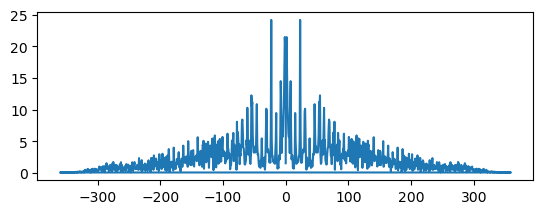

In [33]:
# plotting the FFT of the signal
# fft of the original signal.
org_fft = np.fft.fft(sample_data)
freq = np.fft.fftfreq(sample_data.size, 1/720.)
f1 = plt.figure()
A1 = f1.add_subplot(211)
A1.plot(freq, np.abs(org_fft))
plt.show()

In [34]:
sample_data.shape

(1000,)

In [35]:
org_fft.shape

(1000,)

In [36]:
def lowpass(data: np.ndarray, cutoff: float, sample_rate: float, filter_order: int = 5):
    # Normalize cutoff frequency (Nyquist frequency = sample_rate / 2)
    nyquist = 0.5 * sample_rate
    norm_cutoff = cutoff / nyquist

    # Create a lowpass FIR filter using a windowed sinc function
    t = np.arange(-filter_order // 2, filter_order // 2 + 1)
    h = np.sinc(2 * norm_cutoff * t)
    window = np.hamming(filter_order + 1)
    h = h * window
    h = h / np.sum(h)

    # Apply the filter using 1D convolution
    data_tf = tf.convert_to_tensor(data, dtype=tf.float32)
    h_tf = tf.convert_to_tensor(h, dtype=tf.float32)
    h_tf = tf.reshape(h_tf, [-1, 1, 1])  # Shape [filter_width, in_channels, out_channels]

    data_tf = tf.reshape(data_tf, [1, -1, 1])  # Shape [batch, width, channels]
    filtered_tf = tf.nn.conv1d(data_tf, h_tf, stride=1, padding='SAME')
    filtered_data = tf.squeeze(filtered_tf).numpy()

    return filtered_data

def highpass(data: np.ndarray, cutoff: float, sample_rate: float, filter_order: int = 5):
    # Get lowpass filter
    lowpass_filtered = lowpass(data, cutoff, sample_rate, filter_order)

    # Highpass = original - lowpass (simple spectral inversion)
    highpass_filtered = data - lowpass_filtered
    return highpass_filtered


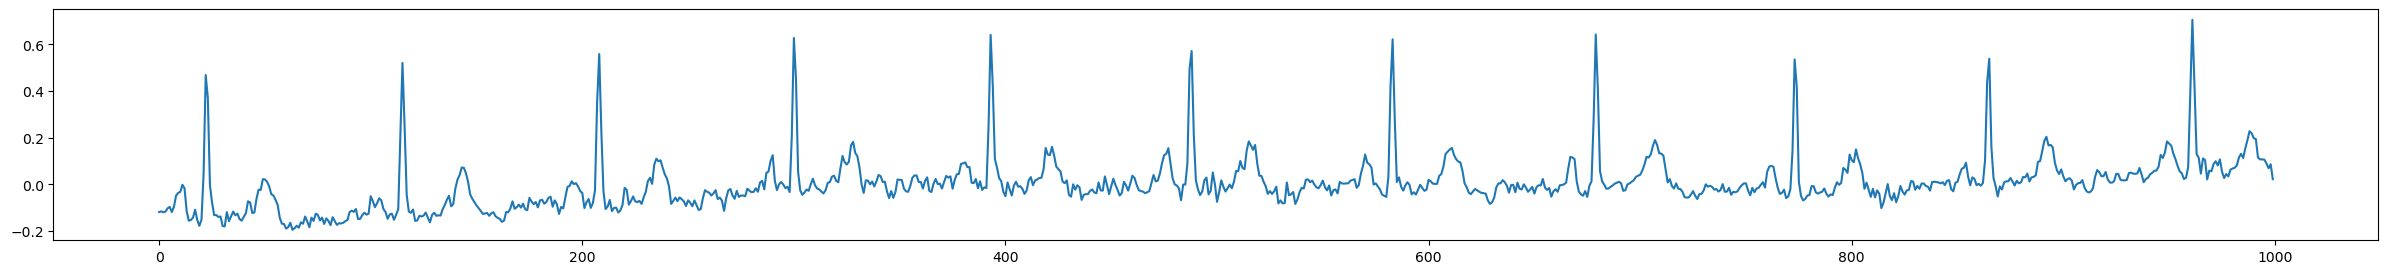

In [37]:
plt.figure(figsize=(30, 3))
plt.plot(sample_data)
plt.show()

In [38]:
low_filtered_data = lowpass(sample_data,30,sampling_rate)

2025-05-05 22:03:33.726210: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-05-05 22:03:33.726238: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-05-05 22:03:33.726247: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-05-05 22:03:33.726301: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-05 22:03:33.726320: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


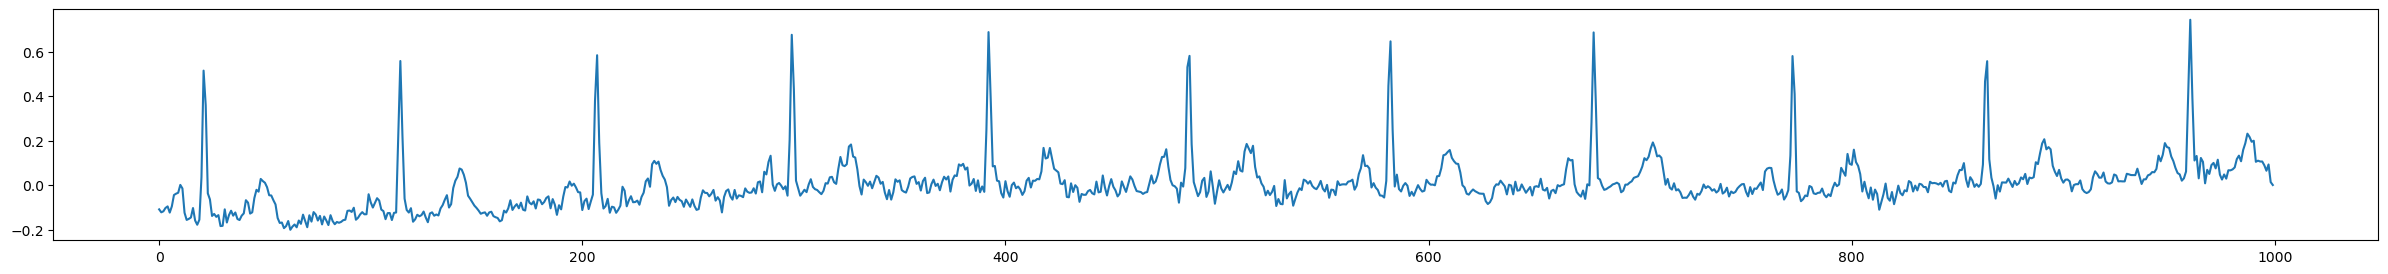

In [39]:
plt.figure(figsize=(30, 3))
plt.plot(low_filtered_data)
plt.show()

In [40]:
filtered_data = highpass(low_filtered_data, 500 , sampling_rate)

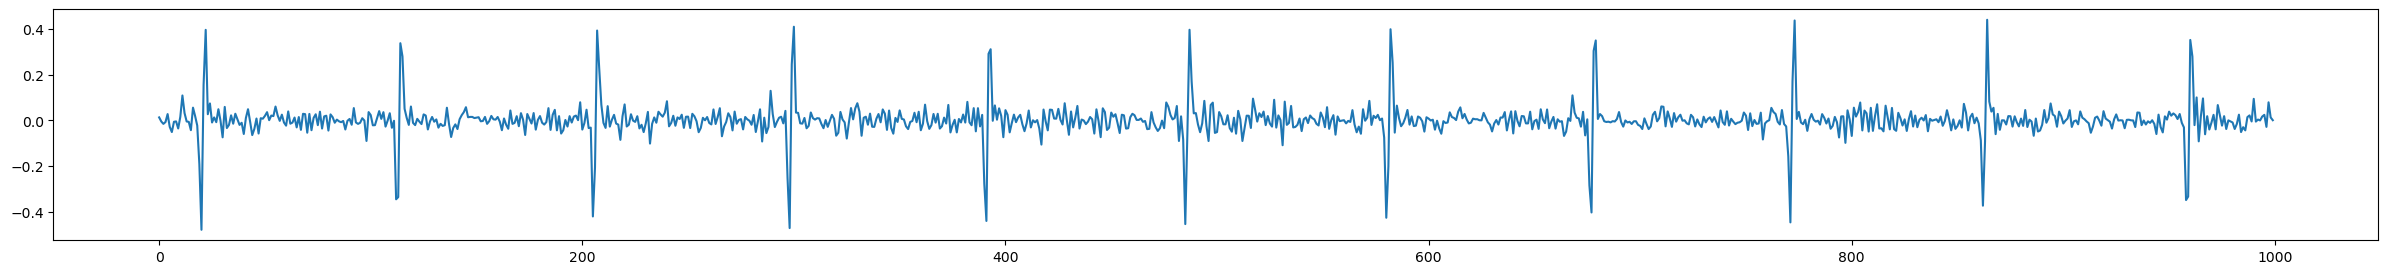

In [41]:
plt.figure(figsize=(30, 3))
plt.plot(filtered_data)
plt.show()

In [42]:
def lowpass_scipy(data: np.ndarray, cutoff: float, sample_rate: float, poles: int = 5):
    sos = signal.butter(poles, cutoff, 'lowpass', fs=sample_rate, output='sos')
    filtered_data = signal.sosfiltfilt(sos, data)
    return filtered_data

def highpass_scipy(data: np.ndarray, cutoff: float, sample_rate: float, poles: int = 5):
    sos = signal.butter(poles, cutoff, 'highpass', fs=sample_rate, output='sos')
    filtered_data = signal.sosfiltfilt(sos, data)
    return filtered_data

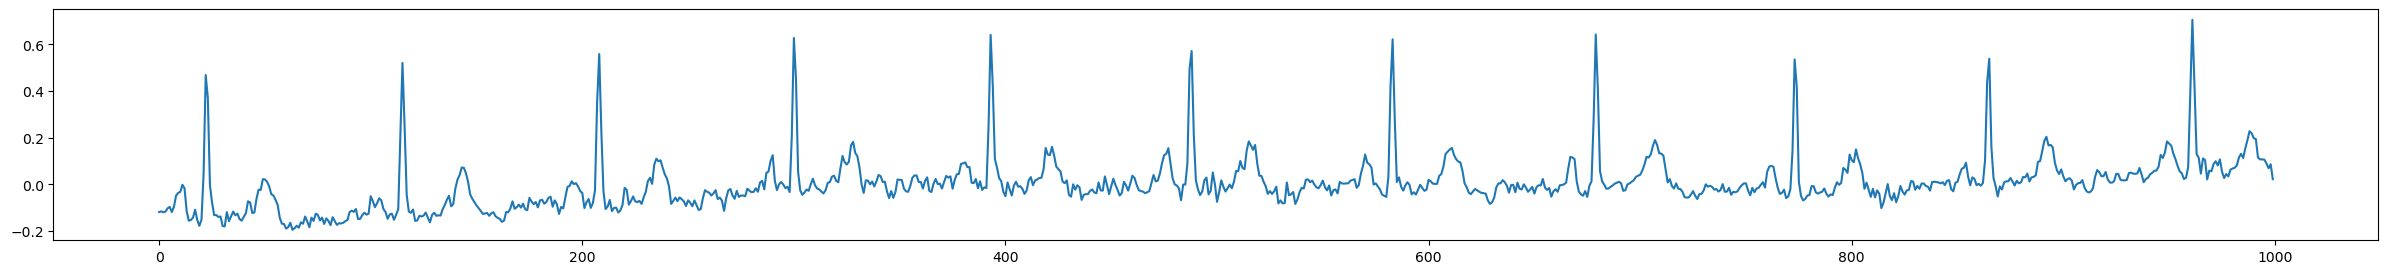

In [43]:
plt.figure(figsize=(30, 3))
plt.plot(sample_data)
plt.show()

In [44]:
high_filtered_data = highpass_scipy(sample_data, 1 , sampling_rate, 7)

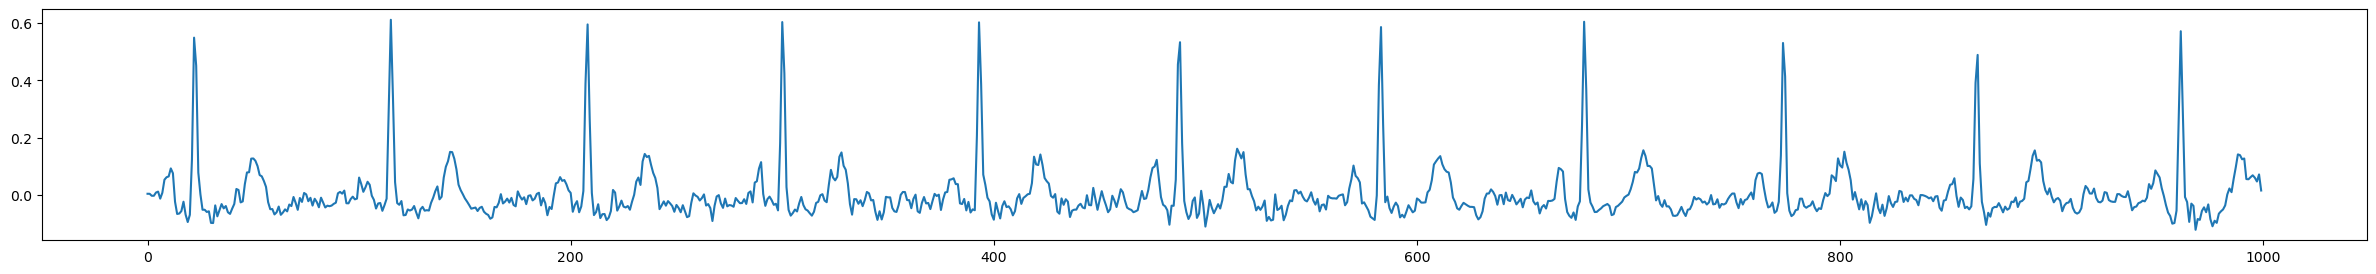

In [45]:
plt.figure(figsize=(30, 3))
plt.plot(high_filtered_data)
plt.show()

In [46]:
low_filtered_data = lowpass_scipy(high_filtered_data,15,sampling_rate)

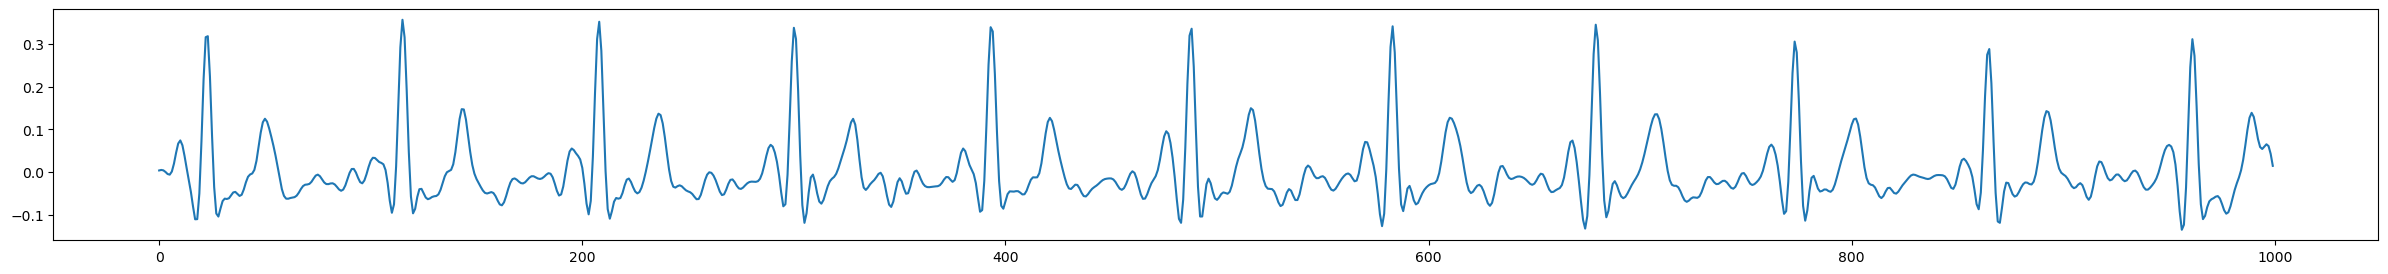

In [47]:
plt.figure(figsize=(30, 3))
plt.plot(low_filtered_data)
plt.show()

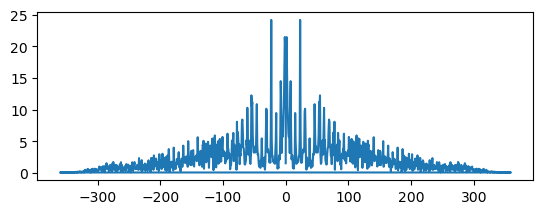

In [48]:
# plotting the FFT of the signal
# fft of the original signal.
org_fft = np.fft.fft(sample_data)
freq = np.fft.fftfreq(sample_data.size, 1/720.)
f1 = plt.figure()
A1 = f1.add_subplot(211)
A1.plot(freq, np.abs(org_fft))
plt.show()

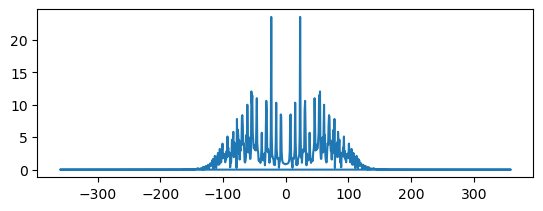

In [49]:
# plotting the FFT of the signal
# fft of the original signal.
org_fft = np.fft.fft(low_filtered_data)
freq = np.fft.fftfreq(low_filtered_data.size, 1/720.)
f1 = plt.figure()
A1 = f1.add_subplot(211)
A1.plot(freq, np.abs(org_fft))
plt.show()

---

new Sample

In [50]:
sample_mi = x_all[y_all['MI']==1].transpose(0, 2, 1)[0][2]

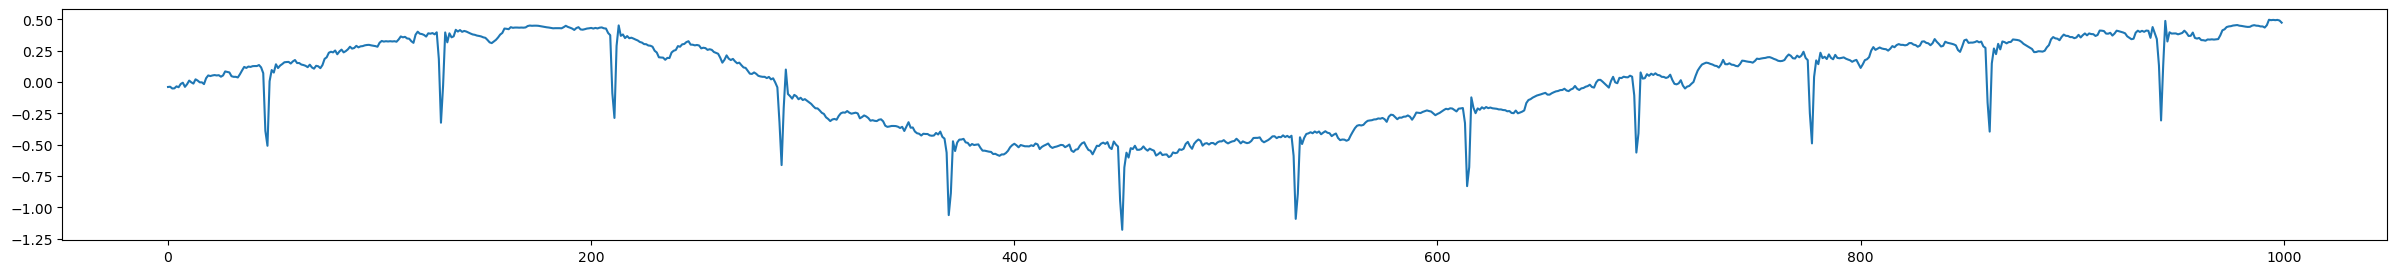

In [51]:
plt.figure(figsize=(30, 3))
plt.plot(sample_mi)
plt.show()

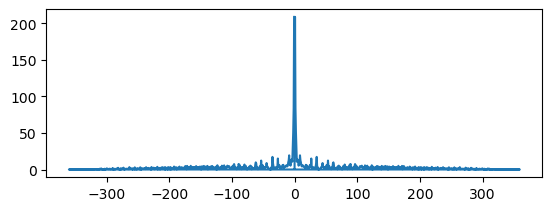

In [52]:
# plotting the FFT of the signal
# fft of the original signal.
org_fft = np.fft.fft(sample_mi)
freq = np.fft.fftfreq(sample_mi.size, 1/720.)
f1 = plt.figure()
A1 = f1.add_subplot(211)
A1.plot(freq, np.abs(org_fft))
plt.show()

In [236]:
high_filtered_data_s2 = highpass_scipy(sample_mi, 1 , sampling_rate, 5)

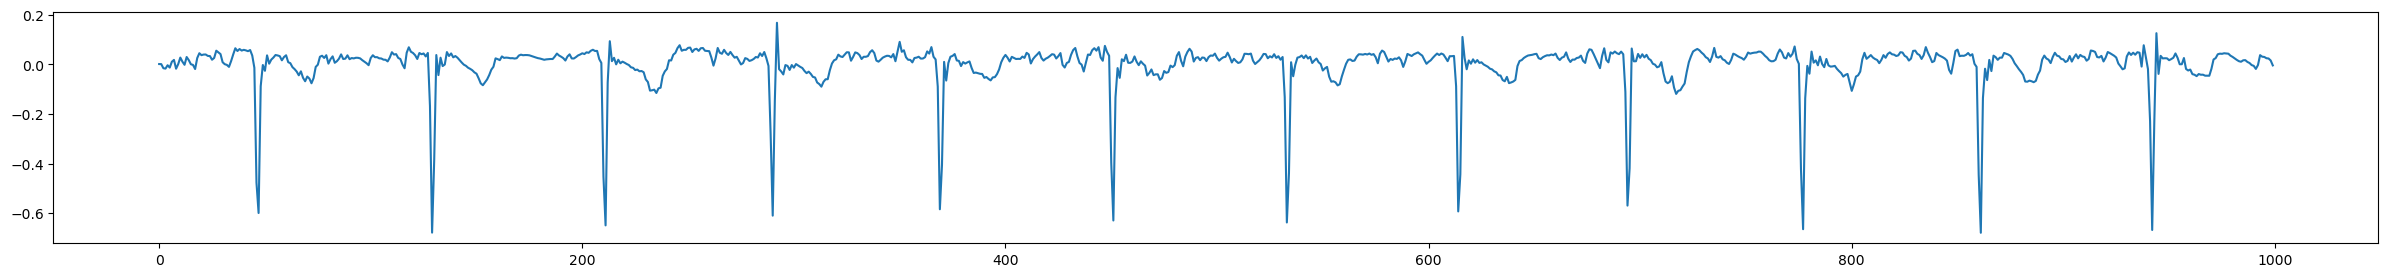

In [237]:
plt.figure(figsize=(30, 3))
plt.plot(high_filtered_data_s2)
plt.show()

In [252]:
low_filtered_data_s2 = lowpass_scipy(high_filtered_data_s2,15, sampling_rate, 5)

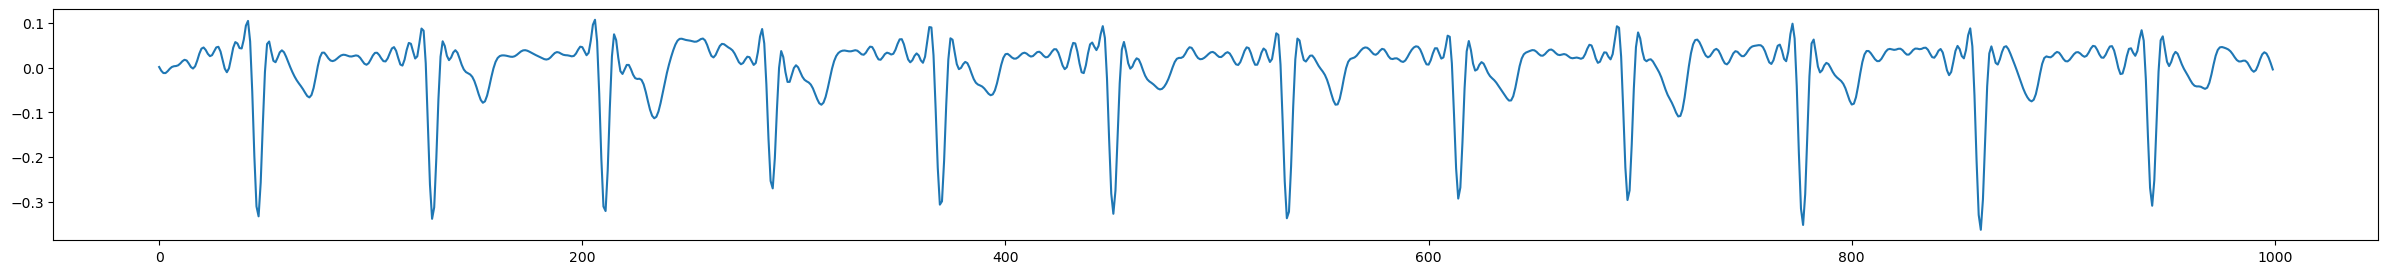

In [253]:
plt.figure(figsize=(30, 3))
plt.plot(low_filtered_data_s2)
plt.show()

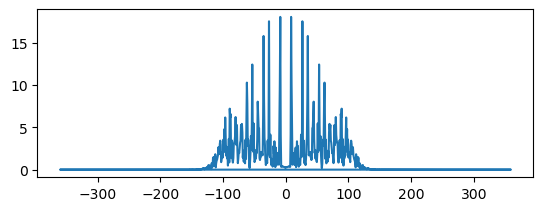

In [57]:
# plotting the FFT of the signal
# fft of the original signal.
org_fft = np.fft.fft(low_filtered_data_s2)
freq = np.fft.fftfreq(low_filtered_data_s2.size, 1/720.)
f1 = plt.figure()
A1 = f1.add_subplot(211)
A1.plot(freq, np.abs(org_fft))
plt.show()

----

12 head pipeline

In [58]:
sample_mi_12h = x_all[y_all['MI']==1].transpose(0, 2, 1)[0]

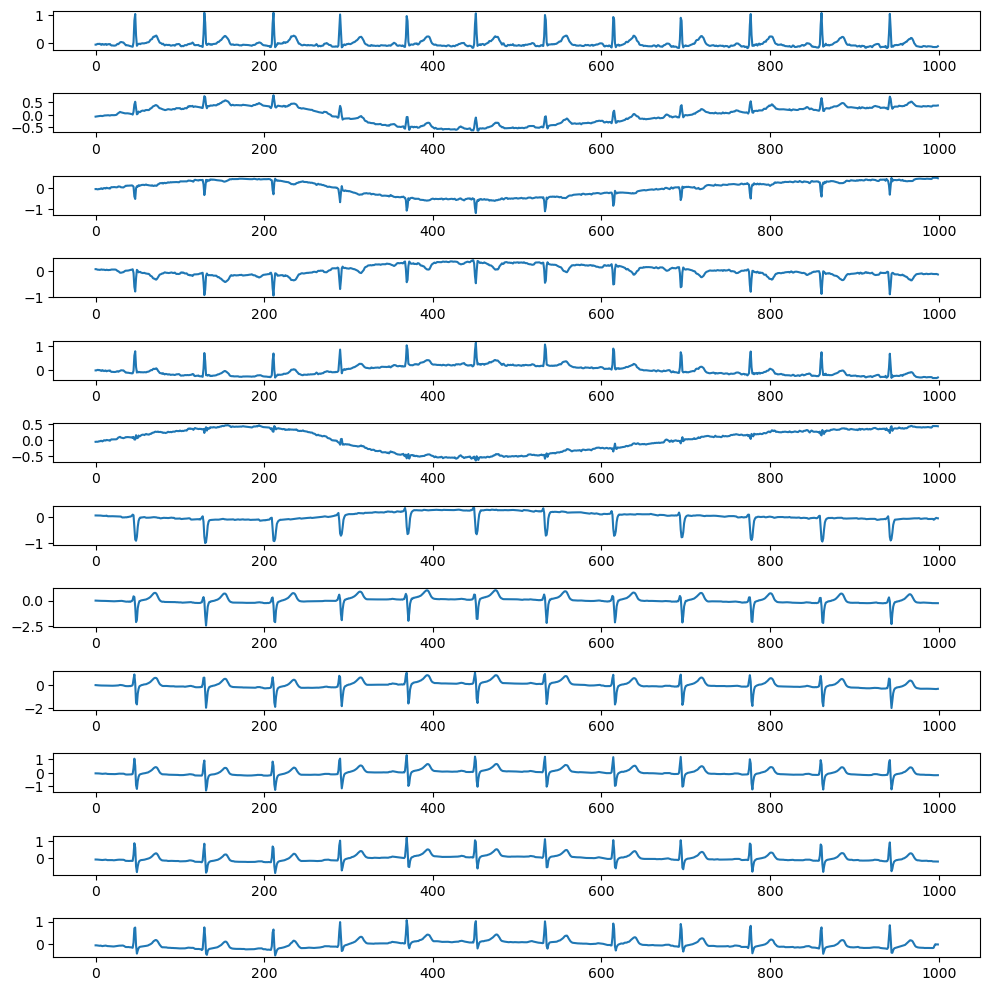

In [59]:
bar, axes = plt.subplots(12, 1, figsize=(10,10))
# plt.figure(figsize=(30, 3))
for idx, ecg_h in enumerate(sample_mi_12h):
    sns.lineplot(ecg_h, ax=axes[idx])
# plt.plot(sample_mi_12h)
plt.tight_layout()
plt.show()

In [60]:
high_filtered_data_12h = highpass_scipy(sample_mi_12h, 1 , sampling_rate, 7)

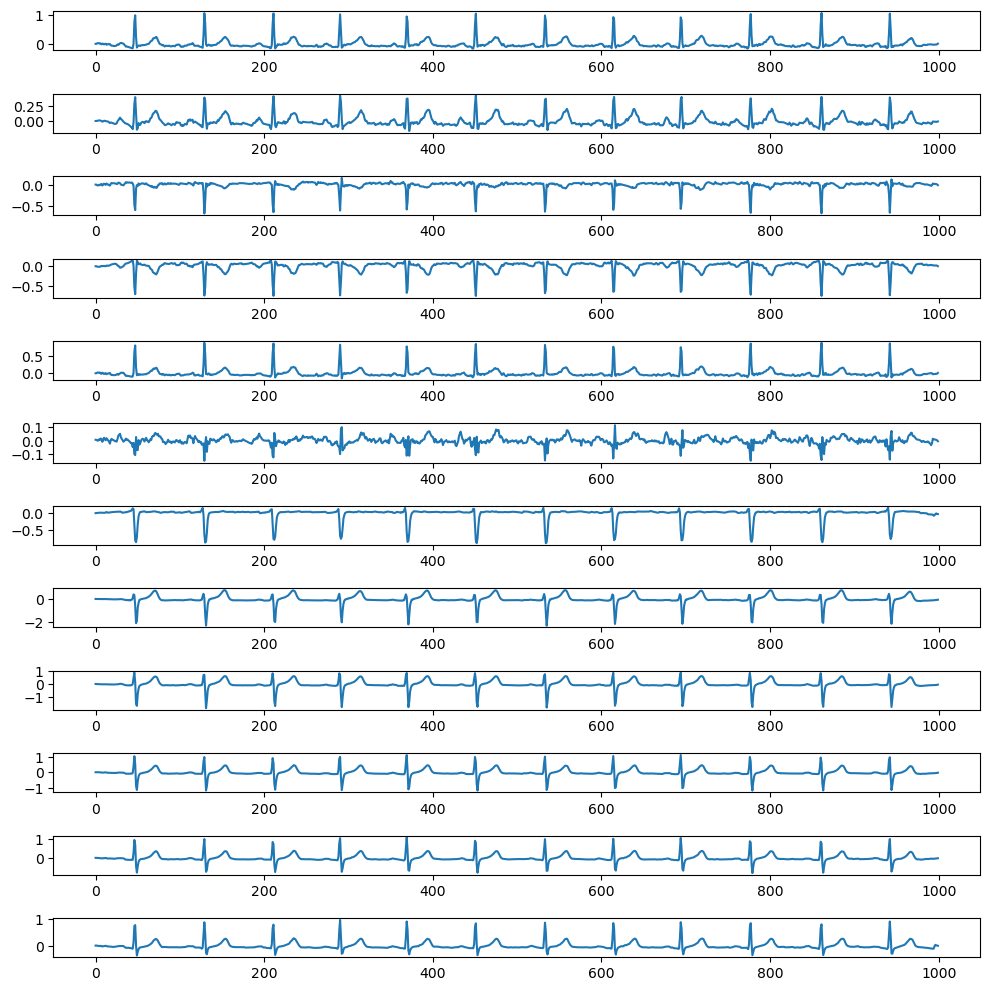

In [61]:
bar, axes = plt.subplots(12, 1, figsize=(10,10))
# plt.figure(figsize=(30, 3))
for idx, ecg_h in enumerate(high_filtered_data_12h):
    sns.lineplot(ecg_h, ax=axes[idx])
# plt.plot(sample_mi_12h)
plt.tight_layout()
plt.show()

In [62]:
low_filtered_data_12h = lowpass_scipy(high_filtered_data_12h,30,sampling_rate)

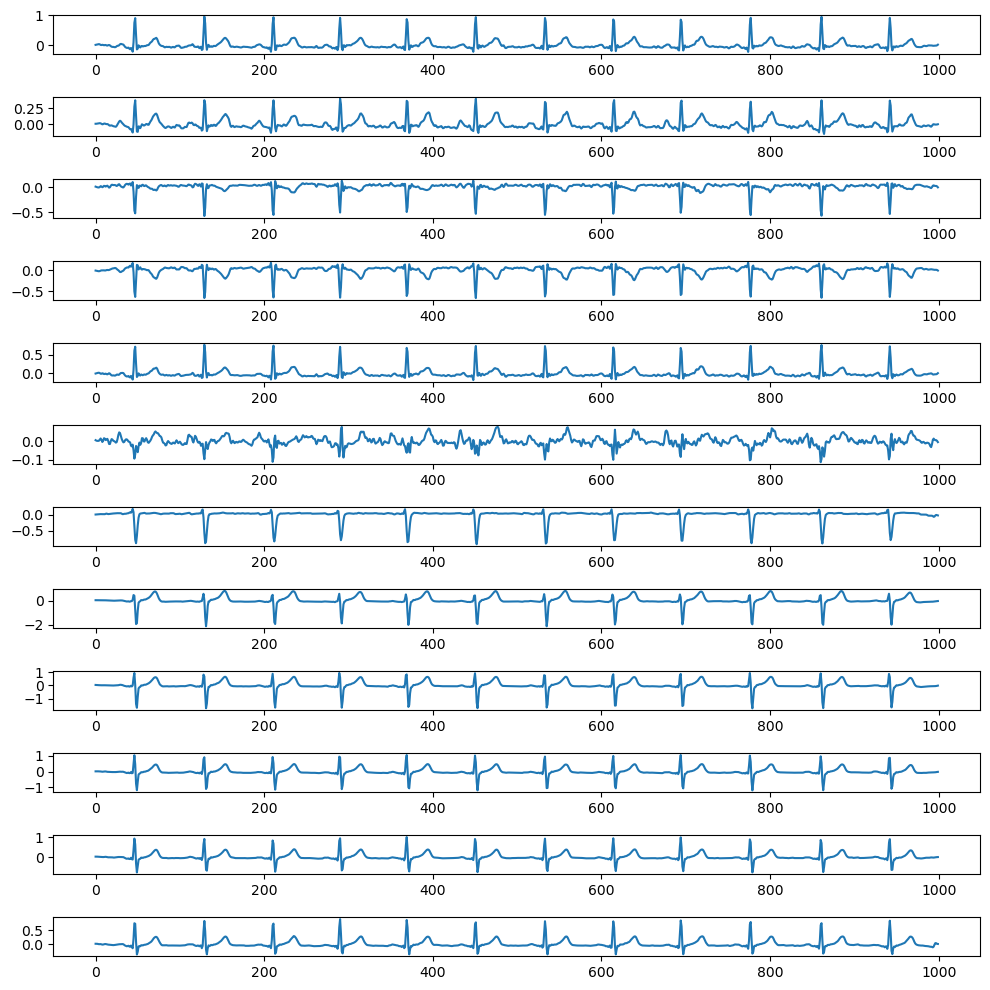

In [63]:
bar, axes = plt.subplots(12, 1, figsize=(10,10))
# plt.figure(figsize=(30, 3))
for idx, ecg_h in enumerate(low_filtered_data_12h):
    sns.lineplot(ecg_h, ax=axes[idx])
# plt.plot(sample_mi_12h)
plt.tight_layout()
plt.show()

In [64]:
low_filtered_data_12h.shape

(12, 1000)

In [65]:
x = 3
y = 5

dummy_array = np.zeros((x,y))

In [66]:
print(dummy_array)


[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [65]:
from tensorflow.keras import Model, Input

In [62]:
resnet18 = None

In [63]:
import resnet
import importlib
importlib.reload(resnet)
resnet18 = resnet.resnet18


In [69]:
inputs = Input(batch_size=12, shape=(24,1000,1))
outputs = resnet18(inputs, num_classes=5)
model = Model(inputs, outputs)
model.summary()


2025-05-25 22:11:58.957103: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-05-25 22:11:58.957204: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-05-25 22:11:58.957219: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-05-25 22:11:58.957242: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-25 22:11:58.957257: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (12, 24, 1000, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (12, 24, 200,     │        640 │ input_layer_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (12, 24, 200,     │        512 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1 (ReLU)        │ (12, 24, 200,     │          0 │ bn1[0][0]         │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (12, 128)         │          0 │ relu1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (12, 128)         │          0 │ relu1[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (12, 128)         │          0 │ relu1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (12, 128)         │          0 │ relu1[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (12, 128)         │          0 │ relu1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (12, 128)         │          0 │ relu1[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (12, 128)         │          0 │ relu1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (12, 128)         │          0 │ relu1[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (12, 128)         │          0 │ relu1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (12, 128)         │          0 │ relu1[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (12, 64)          │      8,192 │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (12, 64)          │      8,192 │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (12, 64)          │      8,192 │ global_average_p

 Total params: 55,326,415 (211.05 MB)

 Trainable params: 55,307,215 (210.98 MB)

 Non-trainable params: 19,200 (75.00 KB)

In [261]:
TrainModel = None

In [262]:
import train_model
import importlib
importlib.reload(train_model)
TrainModel = train_model.TrainModel


In [263]:
model_training = TrainModel()

TypeError: 'NoneType' object is not subscriptable

In [ ]:
sns.relplot(data=pd.DataFrame(history.history), kind='line', height=4, aspect=4)
plt.show()

------

In [36]:
import numpy as np
from scipy.signal import butter, sosfiltfilt


In [37]:
sample_mi_12h = x_all[y_all['MI']==1].transpose(0, 2, 1)[0]

In [38]:
sample_mi_12h.shape

(12, 5000)

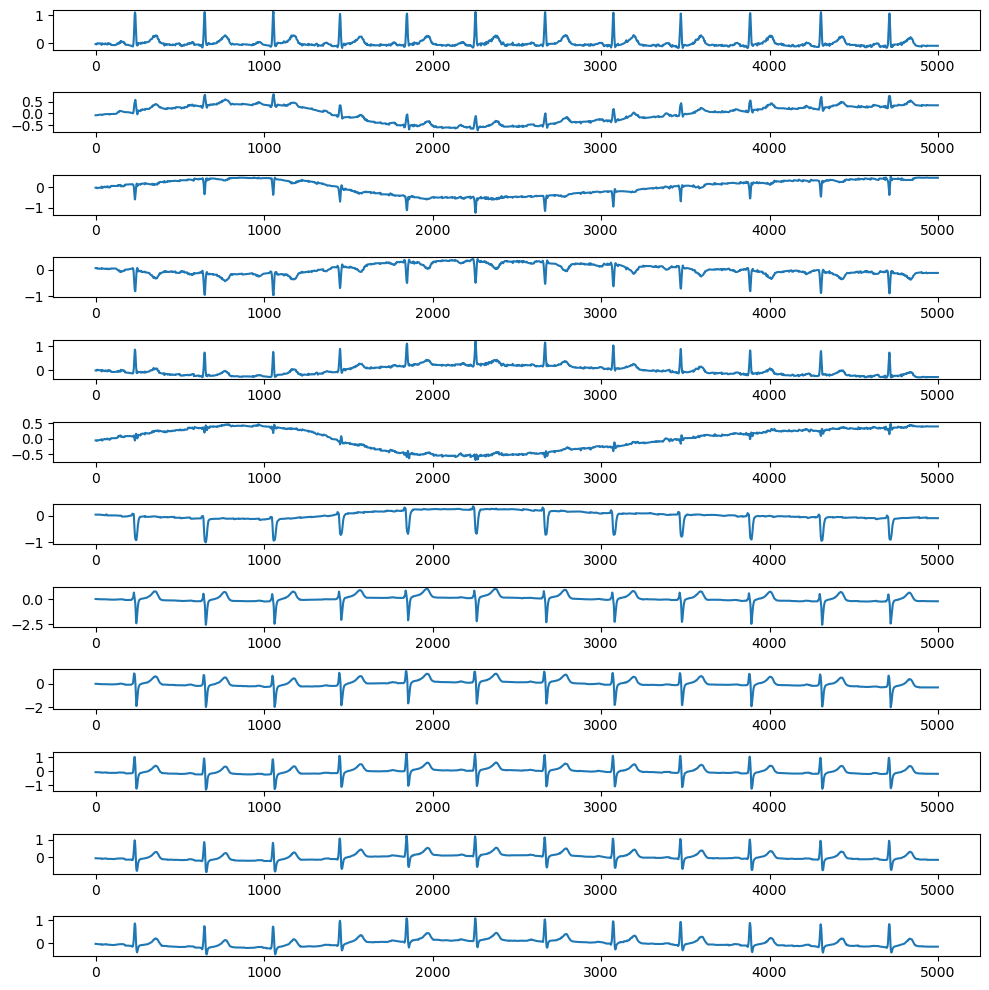

In [39]:
bar, axes = plt.subplots(12, 1, figsize=(10,10))
# plt.figure(figsize=(30, 3))
for idx, ecg_h in enumerate(sample_mi_12h):
    sns.lineplot(ecg_h, ax=axes[idx])
# plt.plot(sample_mi_12h)
plt.tight_layout()
plt.show()

In [40]:

def butter_bandpass_filter(signal, lowcut=0.5, highcut=50.0, fs=500.0, order=5):
    """
    Applies a Butterworth bandpass filter to the input signal.

    Parameters:
    - signal: np.ndarray
        The ECG signal to be filtered.
    - lowcut: float
        The lower cutoff frequency of the filter in Hz.
    - highcut: float
        The upper cutoff frequency of the filter in Hz.
    - fs: float
        The sampling frequency of the signal in Hz.
    - order: int
        The order of the Butterworth filter.

    Returns:
    - filtered_signal: np.ndarray
        The bandpass-filtered ECG signal.
    """
    nyq = 0.5 * fs  # Nyquist Frequency
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', output='sos')
    filtered_signal = sosfiltfilt(sos, signal)
    return filtered_signal

In [41]:
sample_mi_12h_flt = butter_bandpass_filter(sample_mi_12h, lowcut=0.5, highcut=100, fs=500.0, order=5)

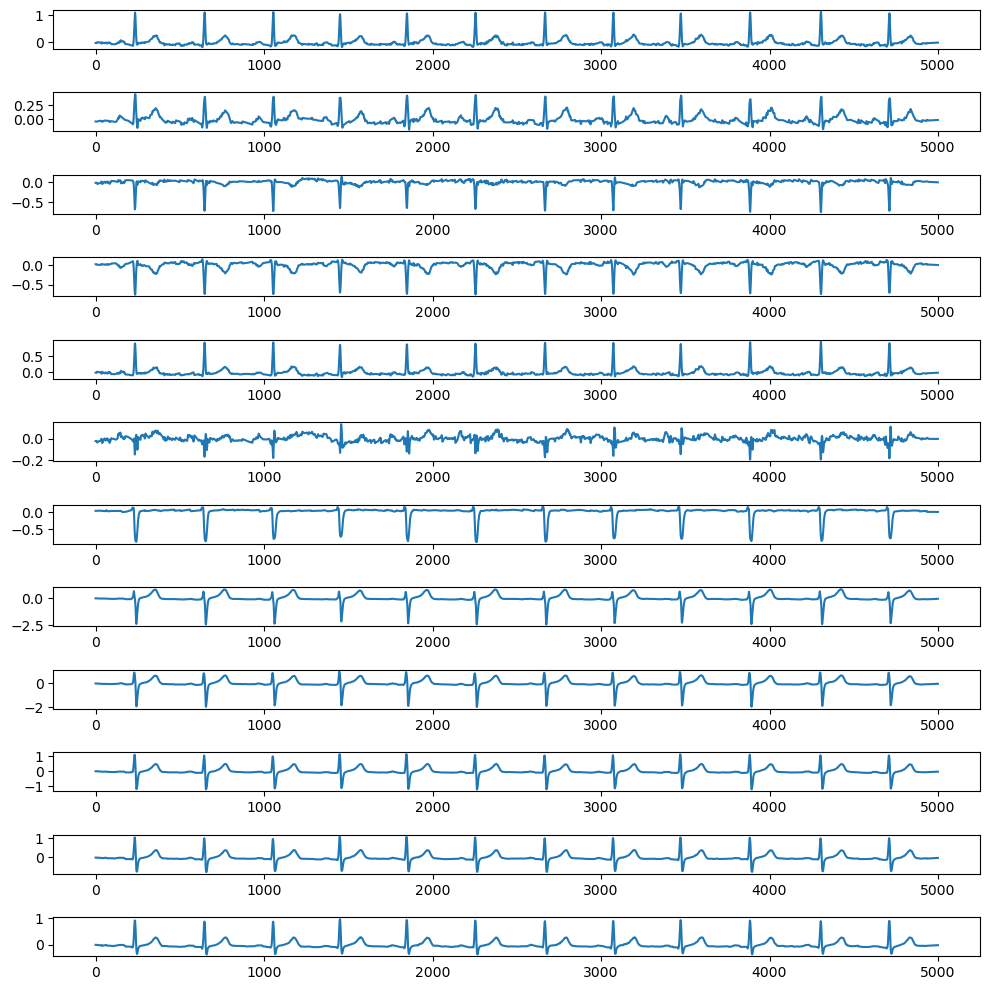

In [42]:
bar, axes = plt.subplots(12, 1, figsize=(10,10))
# plt.figure(figsize=(30, 3))
for idx, ecg_h in enumerate(sample_mi_12h_flt):
    sns.lineplot(ecg_h, ax=axes[idx])
# plt.plot(sample_mi_12h)
plt.tight_layout()
plt.show()

In [ ]:
sample_mi_12h_flt[0]

(12, 1000)

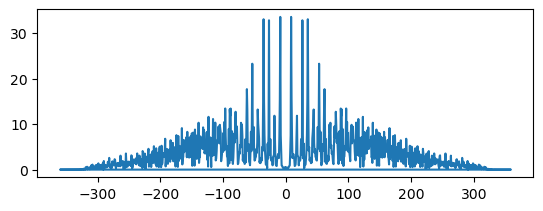

In [51]:
# plotting the FFT of the signal
# fft of the original signal.
org_fft = np.fft.fft(sample_mi_12h_flt[0])
freq = np.fft.fftfreq(sample_mi_12h_flt[0].size, 1/720.)
f1 = plt.figure()
A1 = f1.add_subplot(211)
A1.plot(freq, np.abs(org_fft))
plt.show()

In [52]:
freq.shape

(1000,)

In [57]:
sample_mi_12h_flt_fq = np.array([])

In [59]:
# Option using a list comprehension (recommended for preserving shapes)
fft_results = [np.fft.fft(sig) for sig in sample_mi_12h_flt]
sample_mi_12h_flt_fq = np.array(fft_results)

print("New FFT array shape:", sample_mi_12h_flt_fq.shape)

New FFT array shape: (12, 1000)


In [70]:
dat = np.concatenate((sample_mi_12h_flt,sample_mi_12h_flt_fq), axis=0)

In [71]:
dat.shape

(24, 1000)

In [ ]:
for i , sif in enumerate(sample_mi_12h_flt):
    print(f'{i} : {sif.shape}')

0 : (1000,)
1 : (1000,)
2 : (1000,)
3 : (1000,)
4 : (1000,)
5 : (1000,)
6 : (1000,)
7 : (1000,)
8 : (1000,)
9 : (1000,)
10 : (1000,)
11 : (1000,)


: 

In [ ]:
for i, dp in tqdm(enumerate(self.X_flt_train)):
    fft_results = [np.fft.fft(sig) for sig in dp]
    fft_results = np.array(fft_results)
    self.X_flt_train[i] = np.concatenate((dp,fft_results), axis=0)

In [ ]:
1h
Epoch 70/500
410/410 ━━━━━━━━━━━━━━━━━━━━ 46s 112ms/step - b_acc: 0.8811 - f1_macro: 0.8735 - loss: 0.2415 - precision: 0.8790 - recall: 0.6195 
- val_b_acc: 0.8553 - val_f1_macro: 0.8024 - val_loss: 0.3078 - val_precision: 0.8061 - val_recall: 0.5690

Restoring model weights from the end of the best epoch: 70.
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step   
Classification Report:
              precision    recall  f1-score   support

        NORM       0.82      0.87      0.85      1988
          MI       0.74      0.48      0.58      1079
        STTC       0.59      0.66      0.62       757
         HYP       0.24      0.17      0.20       179
          CD       0.40      0.63      0.49       364

    accuracy                           0.69      4367
   macro avg       0.56      0.56      0.55      4367
weighted avg       0.70      0.69      0.69      4367

Confusion Matrix:
          Predicted
          NORM      MI      STTC     HYP       CD   
Actual
NORM       1736      78       91       20       63   
MI         137      523      206       27      186   
STTC       101       65      497       45       49   
HYP         64       11       27       31       46   
CD          80       33       17       5       229  

In [ ]:
3h
Epoch 63/500
410/410 ━━━━━━━━━━━━━━━━━━━━ 55s 134ms/step - b_acc: 0.8809 - f1_macro: 0.8697 - loss: 0.2411 - precision: 0.8769 - recall: 0.6199 
- val_b_acc: 0.8544 - val_f1_macro: 0.7933 - val_loss: 0.3051 - val_precision: 0.7999 - val_recall: 0.5719

Restoring model weights from the end of the best epoch: 63.
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step
Classification Report:
              precision    recall  f1-score   support

        NORM       0.83      0.85      0.84      1988
          MI       0.71      0.46      0.55      1079
        STTC       0.56      0.65      0.60       757
         HYP       0.26      0.21      0.23       179
          CD       0.41      0.69      0.51       364

    accuracy                           0.68      4367
   macro avg       0.55      0.57      0.55      4367
weighted avg       0.70      0.68      0.68      4367

Confusion Matrix:
          Predicted
          NORM      MI      STTC     HYP       CD   
Actual
NORM       1696      90      110       18       74   
MI         129      491      237       28      194   
STTC        90       70      491       55       51   
HYP         62       12       19       37       49   
CD          59       31       18       4       252 

In [ ]:
4h
Epoch 56/500
410/410 ━━━━━━━━━━━━━━━━━━━━ 53s 129ms/step - b_acc: 0.8740 - f1_macro: 0.8575 - loss: 0.2545 - precision: 0.8665 - recall: 0.6025 
- val_b_acc: 0.8622 - val_f1_macro: 0.8111 - val_loss: 0.2926 - val_precision: 0.8244 - val_recall: 0.5835

Restoring model weights from the end of the best epoch: 56.
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step
Classification Report:
              precision    recall  f1-score   support

        NORM       0.83      0.88      0.85      1988
          MI       0.74      0.46      0.57      1079
        STTC       0.58      0.65      0.61       757
         HYP       0.30      0.26      0.28       179
          CD       0.42      0.70      0.52       364

    accuracy                           0.69      4367
   macro avg       0.58      0.59      0.57      4367
weighted avg       0.71      0.69      0.69      4367

Confusion Matrix:
          Predicted
          NORM      MI      STTC     HYP       CD   
Actual
NORM       1740      76       96       20       56   
MI         129      499      217       29      205   
STTC        98       64      491       56       48   
HYP         53       11       19       47       49   
CD          64       24       17       4       255  

In [ ]:
5h
Epoch 54/500
410/410 ━━━━━━━━━━━━━━━━━━━━ 52s 128ms/step - b_acc: 0.8762 - f1_macro: 0.8612 - loss: 0.2545 - precision: 0.8727 - recall: 0.6057 
- val_b_acc: 0.8570 - val_f1_macro: 0.8008 - val_loss: 0.2994 - val_precision: 0.8149 - val_recall: 0.5677

Restoring model weights from the end of the best epoch: 54.
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step
Classification Report:
              precision    recall  f1-score   support

        NORM       0.84      0.86      0.85      1988
          MI       0.74      0.47      0.57      1079
        STTC       0.58      0.63      0.61       757
         HYP       0.33      0.30      0.31       179
          CD       0.39      0.71      0.50       364

    accuracy                           0.69      4367
   macro avg       0.58      0.59      0.57      4367
weighted avg       0.71      0.69      0.69      4367

In [ ]:
8h
410/410 ━━━━━━━━━━━━━━━━━━━━ 56s 136ms/step - b_acc: 0.8916 - f1_macro: 0.8938 - loss: 0.2179 - precision: 0.9017 - recall: 0.6482 
- val_b_acc: 0.8571 - val_f1_macro: 0.7986 - val_loss: 0.3060 - val_precision: 0.8072 - val_recall: 0.5771

Restoring model weights from the end of the best epoch: 67.
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step
Classification Report:
              precision    recall  f1-score   support

        NORM       0.82      0.85      0.84      1988
          MI       0.71      0.46      0.56      1079
        STTC       0.58      0.62      0.60       757
         HYP       0.31      0.22      0.26       179
          CD       0.38      0.70      0.49       364

    accuracy                           0.68      4367
   macro avg       0.56      0.57      0.55      4367
weighted avg       0.70      0.68      0.68      4367

Confusion Matrix:
          Predicted
          NORM      MI      STTC     HYP       CD   
Actual
NORM       1692      99       98       14       85   
MI         131      500      205       27      216   
STTC       102       71      467       47       70   
HYP         58       12       20       40       49   
CD          69       24       14       1       256 

In [ ]:
11h

Epoch 40/500
410/410 ━━━━━━━━━━━━━━━━━━━━ 62s 152ms/step - b_acc: 0.8721 - f1_macro: 0.8467 - loss: 0.2599 - precision: 0.8624 - recall: 0.5957 
- val_b_acc: 0.8552 - val_f1_macro: 0.7958 - val_loss: 0.3043 - val_precision: 0.8103 - val_recall: 0.5640

Restoring model weights from the end of the best epoch: 40.
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step
Classification Report:
              precision    recall  f1-score   support

        NORM       0.83      0.87      0.85      1988
          MI       0.72      0.44      0.55      1079
        STTC       0.57      0.62      0.59       757
         HYP       0.28      0.21      0.24       179
          CD       0.40      0.71      0.51       364

    accuracy                           0.68      4367
   macro avg       0.56      0.57      0.55      4367
weighted avg       0.70      0.68      0.68      4367

Confusion Matrix:
          Predicted
          NORM      MI      STTC     HYP       CD   
Actual
NORM       1725      78       94       17       74   
MI         141      479      227       20      212   
STTC        90       84      473       54       56   
HYP         60       6        25       37       51   
CD          69       19       14       2       260 

In [ ]:
12h
Epoch 49/500
410/410 ━━━━━━━━━━━━━━━━━━━━ 65s 160ms/step - b_acc: 0.8804 - f1_macro: 0.8689 - loss: 0.2431 - precision: 0.8756 - recall: 0.6173 
- val_b_acc: 0.8587 - val_f1_macro: 0.8015 - val_loss: 0.3008 - val_precision: 0.8164 - val_recall: 0.5746

Restoring model weights from the end of the best epoch: 49.
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step
Classification Report:
              precision    recall  f1-score   support

        NORM       0.85      0.84      0.84      1988
          MI       0.70      0.46      0.56      1079
        STTC       0.56      0.63      0.59       757
         HYP       0.26      0.24      0.25       179
          CD       0.38      0.70      0.49       364

    accuracy                           0.67      4367
   macro avg       0.55      0.57      0.55      4367
weighted avg       0.70      0.67      0.67      4367

Confusion Matrix:
          Predicted
          NORM      MI      STTC     HYP       CD   
Actual
NORM       1664      88      114       24       98   
MI         114      496      228       26      215   
STTC        75       84      480       64       54   
HYP         55       10       20       43       51   
CD          58       30       16       6       254  

In [ ]:
16h
Epoch 36/500
410/410 ━━━━━━━━━━━━━━━━━━━━ 65s 159ms/step - b_acc: 0.8678 - f1_macro: 0.8328 - loss: 0.2725 - precision: 0.8557 - recall: 0.5810 
- val_b_acc: 0.8553 - val_f1_macro: 0.7894 - val_loss: 0.3058 - val_precision: 0.8167 - val_recall: 0.5571

Epoch 56: early stopping
Restoring model weights from the end of the best epoch: 36.
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step
Classification Report:
              precision    recall  f1-score   support

        NORM       0.83      0.87      0.85      1988
          MI       0.71      0.45      0.55      1079
        STTC       0.58      0.60      0.59       757
         HYP       0.26      0.24      0.25       179
          CD       0.38      0.70      0.49       364

    accuracy                           0.68      4367
   macro avg       0.55      0.57      0.55      4367
weighted avg       0.70      0.68      0.67      4367

Confusion Matrix:
          Predicted
          NORM      MI      STTC     HYP       CD   
Actual
NORM       1720      71       86       21       90   
MI         140      482      206       29      222   
STTC        95       89      451       65       57   
HYP         55       11       19       43       51   
CD          65       22       15       7       255

In [80]:
# points = [1,4,8,12,16]
points = [1,3,4,5,8,11,12,16]
val_loss = [0.3078,0.3051,0.2926,0.2994,0.3060,0.3043,0.3008,0.3058]
val_b_acc = [0.8553,0.8544,0.8622,0.8570,0.8571,0.8552,0.8587,0.8553]
val_f1_macro = [0.8024,0.7933,0.8111,0.8008,0.7986,0.7958,0.8015,0.7894]
val_precision = [0.8061,0.7999,0.8244,0.8149,0.8072,0.8103,0.8164,0.8167]
val_recall = [0.5690,0.5719,0.5835,0.5677,0.5771,0.5640,0.5746,0.5571]
stop_epoch = [70,63,56,54,67,40,49,36]

In [81]:
print(f'points: {len(points)}')
print(f'val_loss: {len(val_loss)}')
print(f'val_b_acc: {len(val_b_acc)}')
print(f'val_f1_macro: {len(val_f1_macro)}')
print(f'val_precision: {len(val_precision)}')
print(f'val_recall: {len(val_recall)}')
print(f'stop_epoch: {len(stop_epoch)}')

points: 8
val_loss: 8
val_b_acc: 8
val_f1_macro: 8
val_precision: 8
val_recall: 8
stop_epoch: 8


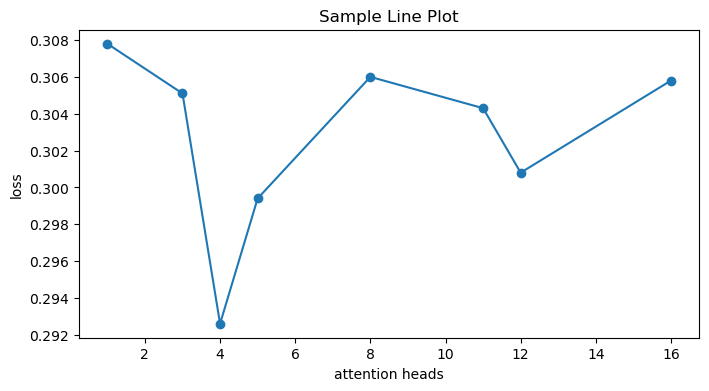

In [82]:
plt.figure(figsize=(8, 4))
plt.plot(points, val_loss, marker='o')
plt.xlabel("attention heads")
plt.ylabel("loss")
plt.title("Sample Line Plot")
plt.show()

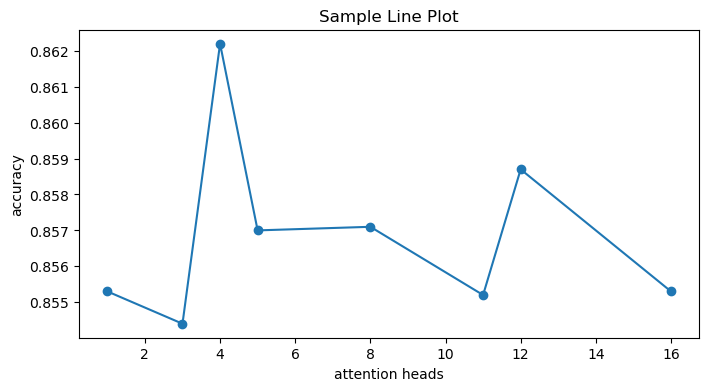

In [83]:
plt.figure(figsize=(8, 4))
plt.plot(points, val_b_acc, marker='o')
plt.xlabel("attention heads")
plt.ylabel("accuracy")
plt.title("Sample Line Plot")
plt.show()

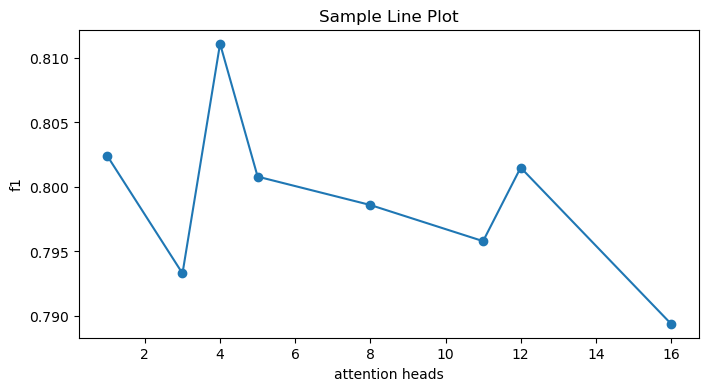

In [84]:
plt.figure(figsize=(8, 4))
plt.plot(points, val_f1_macro, marker='o')
plt.xlabel("attention heads")
plt.ylabel("f1")
plt.title("Sample Line Plot")
plt.show()

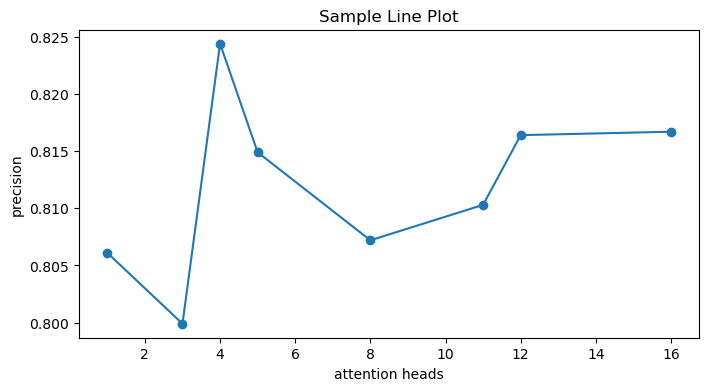

In [85]:
plt.figure(figsize=(8, 4))
plt.plot(points, val_precision, marker='o')
plt.xlabel("attention heads")
plt.ylabel("precision")
plt.title("Sample Line Plot")
plt.show()

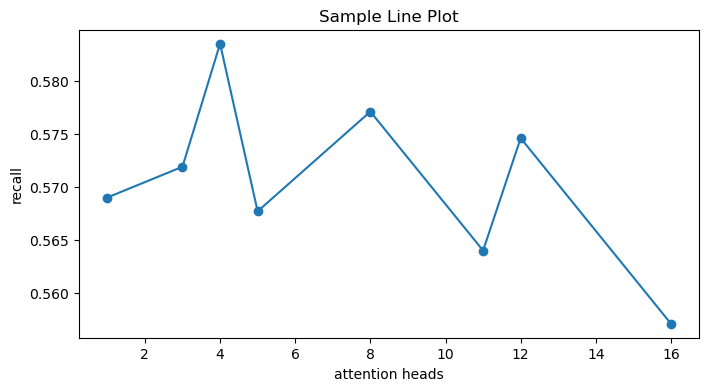

In [86]:
plt.figure(figsize=(8, 4))
plt.plot(points, val_recall, marker='o')
plt.xlabel("attention heads")
plt.ylabel("recall")
plt.title("Sample Line Plot")
plt.show()

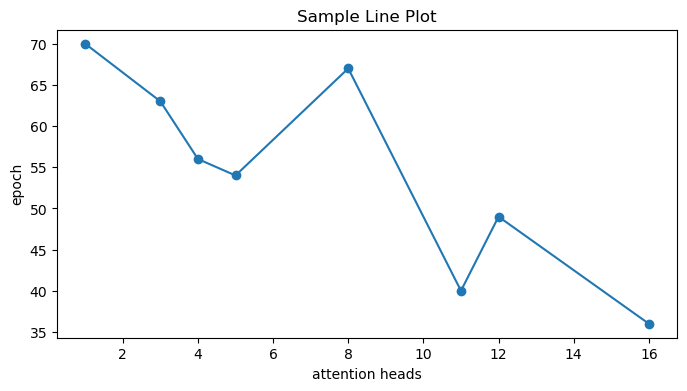

In [87]:
plt.figure(figsize=(8, 4))
plt.plot(points, stop_epoch, marker='o')
plt.xlabel("attention heads")
plt.ylabel("epoch")
plt.title("Sample Line Plot")
plt.show()